# Advanced Lane Finding
## P4 Self Driving Car Nanodegree

### Importing libraries

In [1]:
import cv2
import numpy as np
import os
import glob
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tkinter import *
from PIL import Image,ImageTk
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
%matplotlib inline

In [2]:
## patterns and test images paths. 
patterns_path = 'camera_cal'
test_images_path = 'test_images'
patterns_fn = glob.glob(os.path.join(os.getcwd(),patterns_path, 'calibration*.jpg'))
test_images_fn = glob.glob(os.path.join(os.getcwd(),test_images_path, '*.jpg'))

# Camera calibration

In [3]:
def get_obj_and_img_points(patterns_fn, nx = 9,ny = 6, display = False):
    """function to get the obj poinst and img points for a given set of images paths"""
    obj_points = []
    img_points = []
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    for i in tqdm(range(len(patterns_fn))):
        fn = patterns_fn[i]
        img = cv2.imread(fn)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            if display:
                plt.figure()
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)
    return obj_points, img_points


100%|██████████████████████████████████████████| 20/20 [00:12<00:00,  1.63it/s]


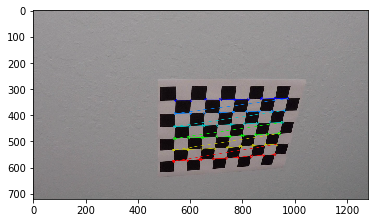

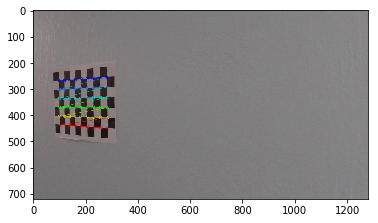

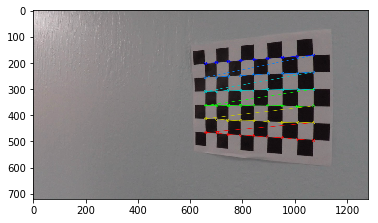

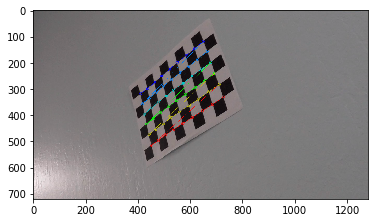

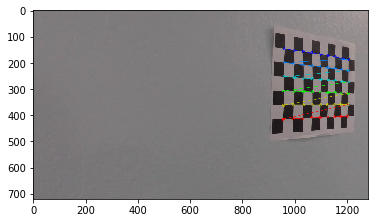

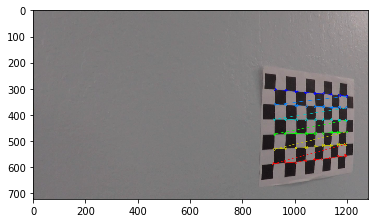

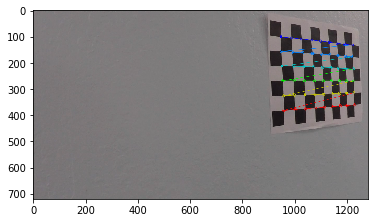

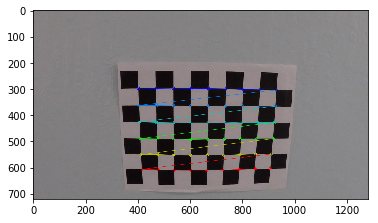

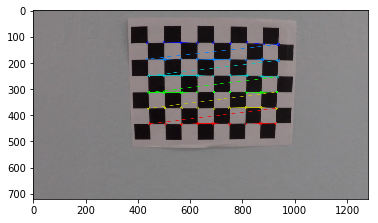

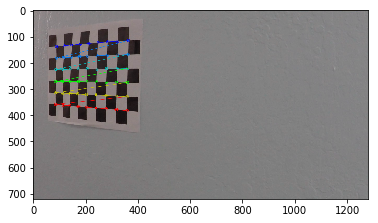

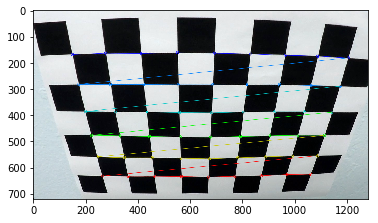

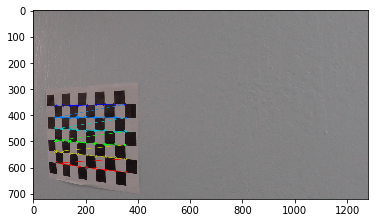

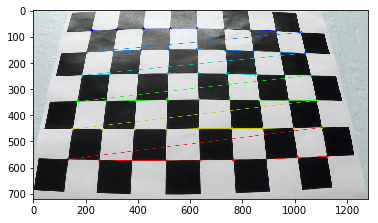

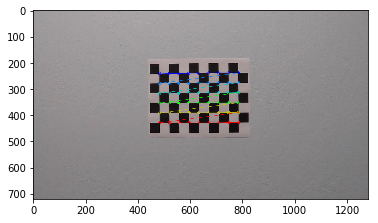

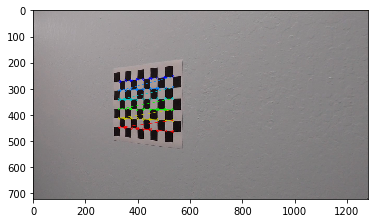

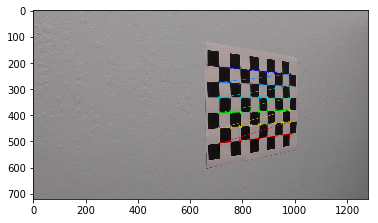

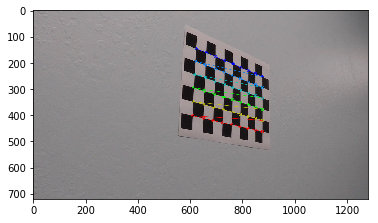

In [4]:
_,_ = get_obj_and_img_points(patterns_fn, display = True)

Obtaining calibration and distortion matrices and save them

In [5]:
try:
    calibration_params = pickle.load(open('calibration_parameters.p', 'rb'))
    print('parameters loaded successfully')
except:
    obj_points, img_points = get_obj_and_img_points(patterns_fn)
    ret, mtx, dist, _, _  = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1],None,None)
    calibration_params = dict([('mtx', mtx), ('dist', dist)])
    pickle.dump(calibration_params, open('calibration_parameters.p', 'wb'))
    print('parameters saved successfully')


parameters loaded successfully


In [6]:
def undistort(image, mtx = calibration_params['mtx'], dist = calibration_params['dist']):
    """simplified undistort function"""
    return cv2.undistort(image, calibration_params['mtx'], calibration_params['dist'], None, calibration_params['mtx'])

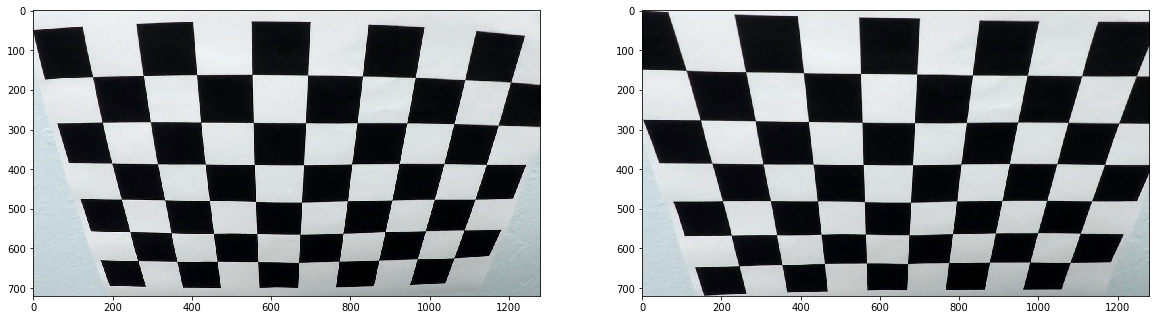

In [7]:
"""example of successful undistortion"""
test_image = cv2.imread(os.path.join(os.getcwd(), patterns_path, 'calibration2.jpg'))
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(test_image)
undist = undistort(test_image)
plt.subplot(122)
plt.imshow(undist)
plt.show()

In [8]:
class FramePopUp():
    """interactive pop up window to get coordinates of interest in order to perform a correct perspective transformation"""
    def __init__(self, input_img):
        self.root = Tk()
        self.width = input_img.shape[1]
        self.height = input_img.shape[0]
        self.frame = Frame(self.root, bd=2, relief=SUNKEN)
        self.frame.grid_rowconfigure(0, weight=1)
        self.frame.grid_columnconfigure(0, weight=1)
        self.canvas = Canvas(self.frame, bd=0, width = self.width, height = self.height)
        self.canvas.grid(row=0, column=0, sticky=N+S+E+W)
        self.frame.pack(fill=BOTH,expand=1)
        self.img = ImageTk.PhotoImage(Image.fromarray(input_img))
        self.canvas.create_image(0,0,image=self.img,anchor="nw")
        self.canvas.bind("<Button 1>",self.savecoords)
        self.src_points = []
        self.click_count = 0
        mainloop()
        
    def savecoords(self,event):
        # Save each coordinate, also display helping guide lines
        self.click_count += 1
        if self.click_count>4:
            self.root.destroy()
            return
        if self.click_count%2 == 1:
            self.canvas.create_line(0, event.y, self.width, event.y)
            self.src_points.append([event.x/self.width , event.y/self.height])
        else:
            self.src_points.append([event.x/self.width, self.src_points[-1][1]])
        self.canvas.create_oval(self.src_points[-1][0]*self.width-2,
                                self.src_points[-1][1]*self.height-2,
                                self.src_points[-1][0]*self.width+2,
                                self.src_points[-1][1]*self.height+2, fill = 'green')
        
    def get_values(self):
        return self.src_points


In [9]:
#saving and loading the source points
try:
    src_points = pickle.load(open('source_points.p', 'rb'))
    print('parameters loaded successfully')
except:
    img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'straight_lines2.jpg')))
    framePopUp = FramePopUp(img)
    src_points = np.float32(framePopUp.get_values())
    pickle.dump(src_points, open('source_points.p', 'wb'))
    print('parameters saved successfully')


parameters loaded successfully


In [10]:
def get_perspective_matrix(input_img, src_points,dst_points):
    # get the perspective transform matrix and the inverse perspective transform matrix
    h, w = input_img.shape[0], input_img.shape[1]
    src = np.float32([[w,h],
                    [w,h],
                    [w,h],
                    [w,h]])*src_points
    dst = np.float32([[w,h],
                    [w,h],
                    [w,h],
                    [w,h]])*dst_points
    return cv2.getPerspectiveTransform(src,dst), cv2.getPerspectiveTransform(dst,src)
    
def change_to_bird_eye(input_img, M):
    #change an image with the corrseponding transform matrix, it keeps the original image dimensions
    h, w = input_img.shape[0], input_img.shape[1]
    return cv2.warpPerspective(input_img, M, (w, h))


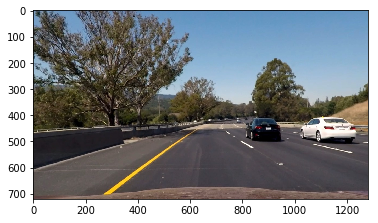

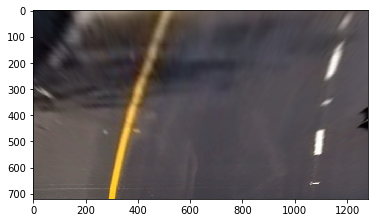

In [11]:
# fixed destination points
dst_points = np.float32([[0.2,0],[0.8,0],[0.2,1],[0.8,1]])
# undistort the image
img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'test6.jpg')))
# convert it to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# display the original and the transformed image
w, h = img.shape[1], img.shape[0]
M, Minv = get_perspective_matrix(img, src_points,dst_points)
bird_eye_view = change_to_bird_eye(img, M)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(bird_eye_view)
plt.show()

In [12]:
def gaussmf(x,thresh = (0,255), mean = None, sigma = None):
    # gauss member function it return a certainty for each pixel given a threshold or mean an sigma values
    if mean == None:
        mean = np.mean(thresh)
    if sigma == None:
        sigma = thresh[1]- thresh[0]
    return np.exp(-((x-mean)**2.)/float(sigma)**2.)

def mag_thresh(input_img, sobel_kernel=3, mag_thresh=(0, 255), fuzzy = True):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    if fuzzy:
        binary_output = gaussmf(scaled_sobel,mag_thresh).astype(np.float32)
        # return a fuzzy mask
    else:
        binary_output = np.zeros_like(scaled_sobel)
        # 6) Return this mask as your binary_output image

        binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])]  = 1
    return binary_output

def dir_threshold(input_img, sobel_kernel=3, thresh=(0, np.pi/2), mean = None, sigma = None,fuzzy = True):
    # Convert to grayscale
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    # Calculate the orientation
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    orientation = np.arctan2(abs_y, abs_x)
    if fuzzy:
        binary_output = gaussmf(orientation,thresh, mean, sigma).astype(np.float32)
        # return a fuzzy mask
    else:
        binary_output = np.zeros_like(orientation)
        binary_output[(orientation >= thresh[0]) & (orientation <= thresh[1])] = 1
        #return a binary mask
        
    return binary_output

def abs_sobel_thresh(input_img, orient='x', thresh=(0,255), sobel_kernel=3, fuzzy = True):
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize = sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    if fuzzy:
        binary_output = gaussmf(scaled_sobel,thresh).astype(np.float32).astype(np.float32)
    else:
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] =  1
    return binary_output

def hls_select(input_img, thresh=(90, 255), fuzzy = True):
    # 1) Convert to HLS color space
    HLS = cv2.cvtColor(input_img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = HLS[:,:,2]
    if fuzzy:
        binary_output = gaussmf(s_channel,thresh).astype(np.float32)
    else:
        binary_output = np.zeros_like(s_channel)
        # 3) Return a binary image of threshold result
        binary_output[(s_channel > thresh[0]) & (s_channel < thresh[1])]  = 1
    return binary_output

def manual_conv_thresh(input_img, top = 0.3, bottom = 0.14, fuzzy = True): 
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    #HLS = cv2.cvtColor(input_img, cv2.COLOR_BGR2HLS)
    high = np.zeros_like(gray)
    low = np.zeros_like(gray)
    weights = np.linspace(top,bottom,gray.shape[0])
    for i, row in enumerate(gray): 
        #val =  min(0.9,max(0.1,-1.64943824e-04*(np.var(HLS[i,:,1]))-3.27541128e-01))
        #high[i,:] = np.convolve(gray[i,:],[-val,-1,-val], 'same')
        #low[i,:] = np.convolve(gray[i,:],[-val,-.1,-val], 'same')
        high[i,:] = np.convolve(gray[i,:],[-weights[i],-1,-weights[i]], 'same')
        low[i,:] = np.convolve(gray[i,:],[-weights[i],-.1,-weights[i]], 'same')
    if fuzzy:
        binary_output = np.maximum(gaussmf(high,(200,255)),gaussmf(low,(0,180))).astype(np.float32)
    else:
        binary_output = np.bitwise_or(high>200,low<180).astype('int')
    return binary_output

def combined_thresholds(input_img, display = False):
    ksize = 5
    gradx = abs_sobel_thresh(input_img, orient='x', sobel_kernel=ksize, thresh=(80, 130))
    grady = abs_sobel_thresh(input_img, orient='y', sobel_kernel=ksize, thresh=(80, 130))
    mag_binary = mag_thresh(input_img, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(input_img, sobel_kernel=15, mean = 0, sigma = .75, fuzzy = True)
    neg_dir_binary = dir_threshold(input_img, sobel_kernel=15, mean = 1.57, sigma = 0.2, fuzzy = True)
    conv_binary = manual_conv_thresh(input_img, top = 0.3, bottom = 0.14)
    hls_binary = hls_select(input_img, thresh = (70,255))
    gray = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
    auto_thresh_binary = cv2.adaptiveThreshold(gray,1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,75,10)
    lab = cv2.cvtColor(input_img, cv2.COLOR_RGB2LAB)
    r_filter = gaussmf(input_img[:,:,0], mean = 220, sigma = 50)
    g_filter = gaussmf(input_img[:,:,1], mean = 200, sigma = 50)
    lab_filter_yellow = gaussmf(lab[:,:,2], mean = 150, sigma = 70)
    lab_filter_white = gaussmf(lab[:,:,0], mean = 240, sigma = 25)
    red_and_green = np.maximum(r_filter, g_filter)
    white_and_yellow = np.maximum( lab_filter_yellow, lab_filter_white)
    colors = np.maximum(red_and_green, white_and_yellow)
    grads = np.maximum(gradx, grady )
    magdir = 0.8* mag_binary + 0.2 * np.minimum(mag_binary, dir_binary)
    convhls = hls_binary + 0.32 * conv_binary
    combined_fuzzy = grads + 0.35 * magdir + 0.3 * convhls + 0.3 * auto_thresh_binary - neg_dir_binary + colors
    combined_fuzzy = combined_fuzzy +0.5*r_filter+0.5*g_filter
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[combined_fuzzy>.8] = 1
    if display:
        images = [gradx, grady, grads, mag_binary, dir_binary, magdir,
                  neg_dir_binary, hls_binary, conv_binary, 
                  auto_thresh_binary, lab_filter_yellow,
                  lab_filter_white, r_filter, g_filter, combined_fuzzy, combined_binary]
        titles = ['Horizontal gradient', 'Vertical gradient', 'Horizontal and vertical gradients Combined',
                 'Magnitude gradient', 'Direction gradient', 'Magnitude and direction Combined','Negative Direction gradient',
                 'Saturation channel', 'Custom convolution', 'Adaptive threshold','lab filter 1', 'lab filter 2', 'red filter',
                 'green filter', 'Fuzzy Combined', 'Binary_combined']
        fig, axes = plt.subplots(4, 4,figsize = (20,10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(images[i], cmap = 'gray')
            ax.set_title(titles[i])
            ax.axis('off')
    return combined_binary, combined_fuzzy


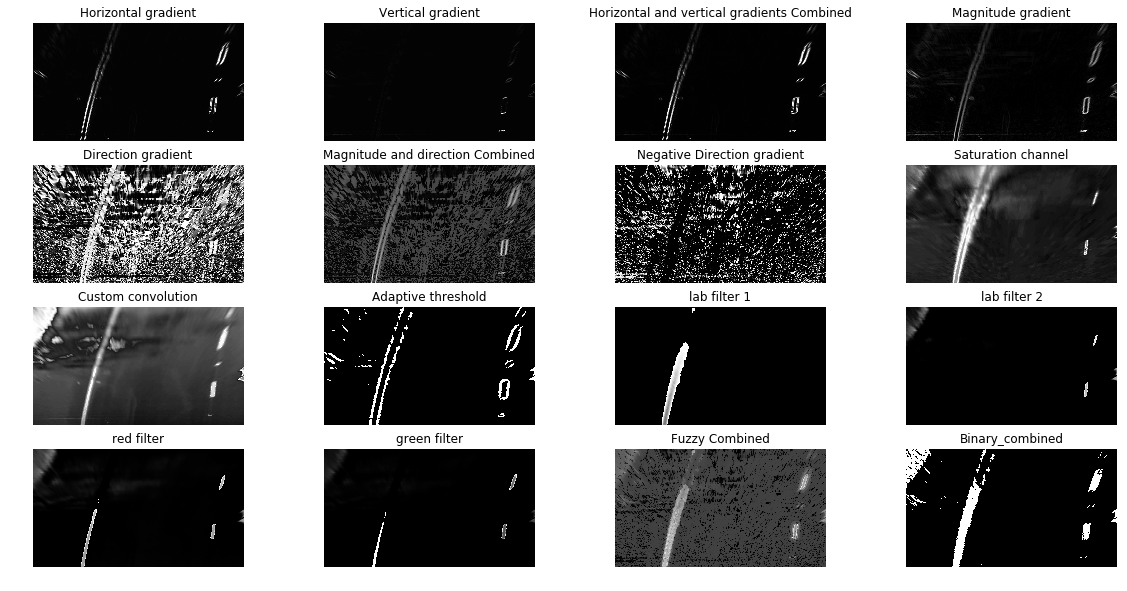

In [13]:
combined, _= combined_thresholds(bird_eye_view, display = True)

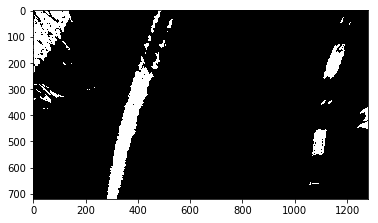

In [14]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap = 'gray')

In [15]:
class Line():
    offset = 0
    def __init__(self, color = None):
        # was the line detected in the last iteration?
        self.detected = False  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        self.x_points = None
        self.y_points = None
        
        self.all_coef = deque([], maxlen = 10)
        self.last_fit_coef = None
        
        self.poly = None
        
        self.image = None
        self.color = color
        
    def coef_update(self, new_coef):
        self.last_fit_coef = new_coef
        if len(self.all_coef)>0:
            if ~np.any((np.log10(np.abs(self.get_median_coef()- new_coef))>[-1,-1,5])):
                self.all_coef.append(new_coef)
                self.detected = True
            else:
                self.detected = False
        else:
            self.all_coef.append(new_coef)
        self.all_coef.append(new_coef)
        
    def get_median_coef(self):
        return np.median(self.all_coef, axis = 0)

In [16]:
lines = {'left': Line('red'), 'right':Line('blue')}

In [17]:
def find_lane_lines(binary_image, line, mean, windows_height = 50, min_width = 50, max_width = 150, display = False):
    if display:
        fig = plt.figure(figsize = (20,10))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122, projection='3d')
        ax1.imshow(binary_image, cmap = 'gray')
    windows_width = max_width
    line_image = np.zeros_like(binary_image)
    if display:
        sequence = tqdm(range(binary_image.shape[0],0,-windows_height))
    else:
        sequence = range(binary_image.shape[0],0,-windows_height)
    for i in sequence:
        x = np.linspace(0,binary_image.shape[1]-1,binary_image.shape[1],dtype = 'int')
        x = x[mean-windows_width:mean+windows_width]
        y = np.sum(binary_image[i-windows_height:i,mean-windows_width:mean+windows_width], axis = 0)
        if display:
            ax1.add_patch(patches.Rectangle((mean-windows_width,i-windows_height), 2*windows_width,windows_height, fill = False,edgecolor=line.color))
        if len(y)>0:
            if np.max(y)>5: 
                mean = int(x[int(np.median(np.argwhere(y==np.max(y))))])
                windows_width = max(min_width, windows_width-50)
            else:
                windows_width = min(max_width, windows_width+10)
        line_image[i-windows_height:i,mean-windows_width:mean+windows_width] = binary_image[i-windows_height:i,mean-windows_width:mean+windows_width]    
        if display:
            ax2.bar(x,y,i,zdir='y',color = line.color)
        line.image = line_image
        line.y_points,line.x_points = np.nonzero(line.image)

100%|██████████████████████████████████████████| 29/29 [00:07<00:00,  3.72it/s]


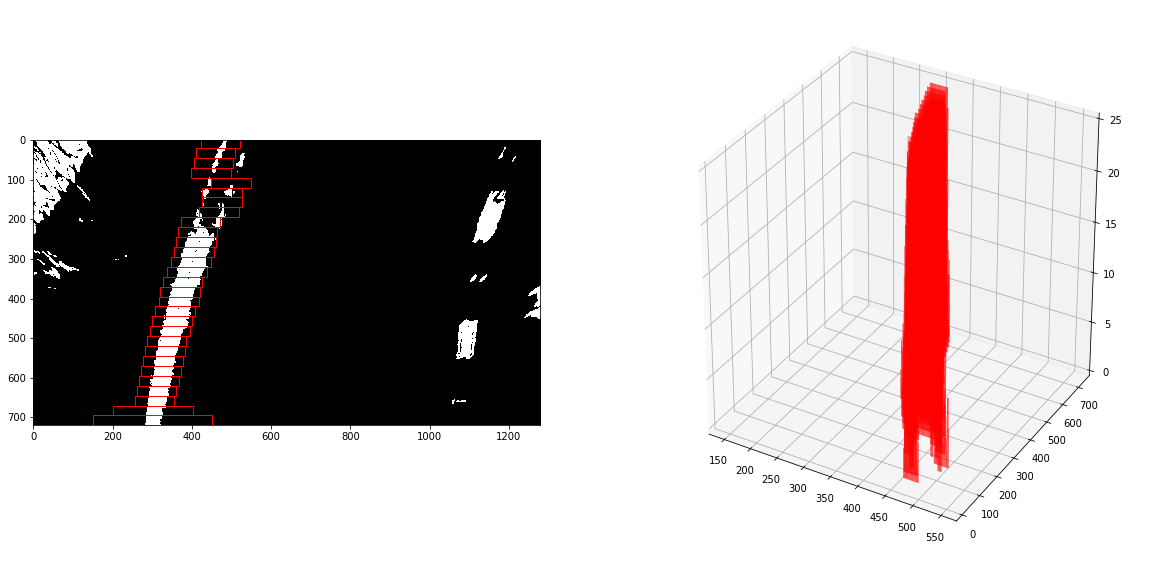

In [18]:
find_lane_lines(opening, lines['left'], 300, windows_height = 25, display = True)

100%|██████████████████████████████████████████| 29/29 [00:10<00:00,  3.57it/s]


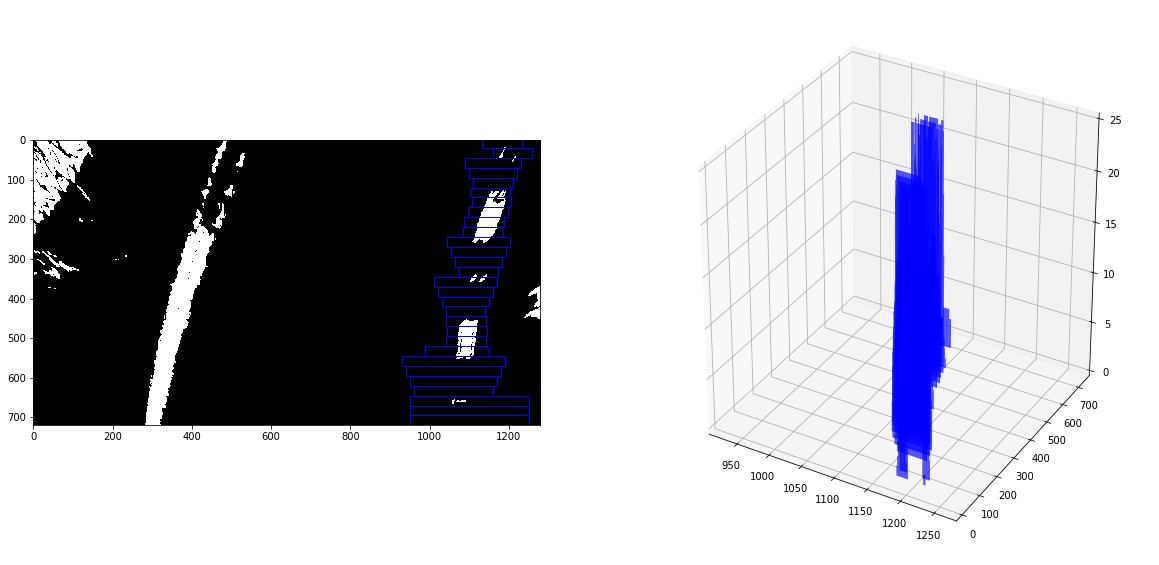

In [19]:
find_lane_lines(opening, lines['right'], 1100, windows_height = 25, display = True)

In [20]:
def find_lane_lines_with_coef(binary_image, line, margin = 100):
    fit_coef = line.get_median_coef()
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    lane_inds = ((nonzerox > (fit_coef[0]*(nonzeroy**2) + fit_coef[1]*nonzeroy + fit_coef[2] - margin)) & (nonzerox < (fit_coef[0]*(nonzeroy**2) + fit_coef[1]*nonzeroy + fit_coef[2] + margin))) 
    line.x_points = nonzerox[lane_inds]
    line.y_points = nonzeroy[lane_inds] 
    

In [22]:
def fit_lines(input_img, lines):
    if (len(lines['left'].all_coef)<1):
        find_lane_lines(opening, lines['left'], 300,  windows_height = 25, min_width = 30)
    else:
        find_lane_lines_with_coef(input_img,lines['left'])
    if (len(lines['right'].all_coef)<1):
        find_lane_lines(opening, lines['right'], 1100, windows_height = 25, min_width = 30)
    else:
        find_lane_lines_with_coef(input_img,lines['right'])
    if len(lines['left'].x_points)>0:
        lines['left'].coef_update(np.polyfit(lines['left'].y_points,lines['left'].x_points,2))
    if len(lines['right'].x_points)>0:
        lines['right'].coef_update(np.polyfit(lines['right'].y_points,lines['right'].x_points,2))
    lines['left'].poly = np.poly1d(lines['left'].get_median_coef())
    lines['right'].poly = np.poly1d(lines['right'].get_median_coef())
fit_lines(opening, lines)

In [23]:
def retrive_curvature_and_offset(lines, y_eval, xm_per_pix = 3.7/700,ym_per_pix = 30/720):
    # Fit new polynomials to x,y in world space
    if len(lines['left'].x_points)>0:
        left_fit_cr = np.polyfit(lines['left'].y_points*ym_per_pix,lines['left'].x_points*xm_per_pix, 2)
        lines['left'].radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

    if len(lines['right'].x_points)>0:
        right_fit_cr = np.polyfit(lines['right'].y_points*ym_per_pix,lines['right'].x_points*xm_per_pix, 2)
        lines['right'].radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    if (len(lines['left'].x_points)>0) and (len(lines['right'].x_points)>0):
        Line.offset = (img.shape[1]/2-(lines['right'].poly(img.shape[0])+lines['left'].poly(img.shape[0]))/2)*xm_per_pix*100
    return lines['left'].radius_of_curvature, lines['right'].radius_of_curvature, Line.offset
left_curverad, right_curverad, offset = retrive_curvature_and_offset(lines,h)
print(left_curverad, right_curverad, offset )

2693.1483853 904.403006026 -23.9725213391


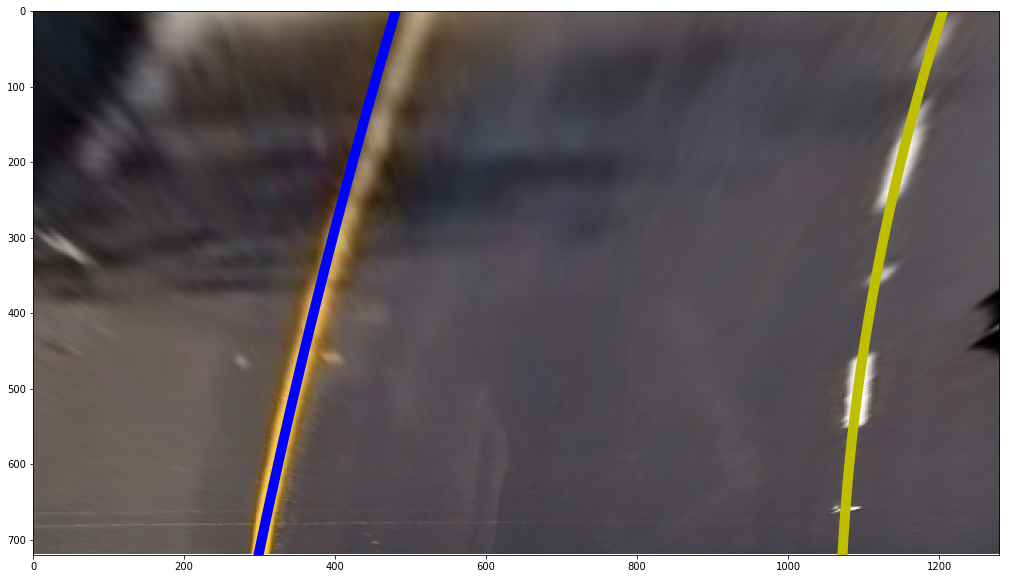

In [24]:
y_points = np.linspace(0,h, 100)

plt.figure(figsize = (20,10))
axes = plt.gca()
axes.set_xlim([0,1280])
axes.set_ylim([720,0])
plt.imshow(bird_eye_view)
plt.plot(lines['left'].poly(y_points),y_points,  linewidth = 10, color = 'b' )
plt.plot(lines['right'].poly(y_points),y_points, linewidth = 10, color = 'y')
plt.show()


In [25]:
def get_virtual_lane(input_image, lines):
    output_image = np.zeros_like(input_image).astype(np.uint8)    
    pts_left = np.array([np.transpose(np.vstack([lines['left'].poly(y_points), y_points]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([lines['right'].poly(y_points), y_points])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(output_image, np.int_([pts]), (55,174, 105))
    return cv2.warpPerspective(output_image, Minv, (output_image.shape[1], output_image.shape[0]))

def get_lanes_lines_mask(input_image, lines, width = 20):

    output_image = np.zeros(input_image.shape[0:2])
    print(output_image.shape)
    pts_left_border_1 = np.array([np.transpose([lines['left'].poly(y_points)- width, y_points])])
    pts_left_border_2 = np.array([np.flipud(np.transpose([lines['left'].poly(y_points) + width, y_points]))])
    left_border_points = np.hstack((pts_left_border_1,pts_left_border_2))
    cv2.fillPoly(output_image, np.int_([left_border_points]), 1)
    pts_right_border_1 = np.array([np.transpose([lines['right'].poly(y_points)-width, y_points])])
    pts_right_border_2 = np.array([np.flipud(np.transpose([lines['right'].poly(y_points)+width, y_points]))])
    right_border_points = np.hstack((pts_right_border_1,pts_right_border_2))
    cv2.fillPoly(output_image, np.int_([right_border_points]),1)
    return cv2.warpPerspective(output_image, Minv, (output_image.shape[1], output_image.shape[0]))

def overlay_text(input_image, left_curverad,right_curverad,offset):
    text1 = 'Curve radius: ' + '{:.0f} m'.format(np.mean([left_curverad,right_curverad]))
    text2 = 'Offset: ' + '{:.2f} cm'.format(offset) 
    cv2.putText(input_image, text1, (550,625), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (10,25,20),2)
    cv2.putText(input_image, text2, (550,650), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (10,25,20),2)

In [26]:
lines = {'left': Line(), 'right':Line()}
def process_video(frame):
    undist = undistort(frame)
    bird_eye_view = change_to_bird_eye(undist, M)
    combined, combined_fuzzy = combined_thresholds(bird_eye_view)
    small_combined_fuzzy = cv2.resize(combined_fuzzy, (128,72))
    small_combined_binary = cv2.resize(combined, (128,72))
    opening = cv2.morphologyEx(combined, cv2.MORPH_OPEN, kernel)
    fit_lines(opening, lines)
    left_curverad, right_curverad, offset = retrive_curvature_and_offset(lines,h)
    lane_overlay = get_virtual_lane(frame,lines)
    lane_lines_overlay = get_lanes_lines_mask(frame, lines)
    result = cv2.addWeighted(frame, 1, lane_overlay, 0.3, 0)
    result[np.nonzero(lane_lines_overlay)] = [0,0, 255]
    overlay_text(result, left_curverad,right_curverad,offset)
    
    result[0:72,0:128] = cv2.cvtColor((255*small_combined_fuzzy).astype('uint8'), cv2.COLOR_GRAY2RGB)
    result[0:72,128:256] = cv2.cvtColor(255*small_combined_binary.astype('uint8'), cv2.COLOR_GRAY2RGB)
    return result
    

(720, 1280)


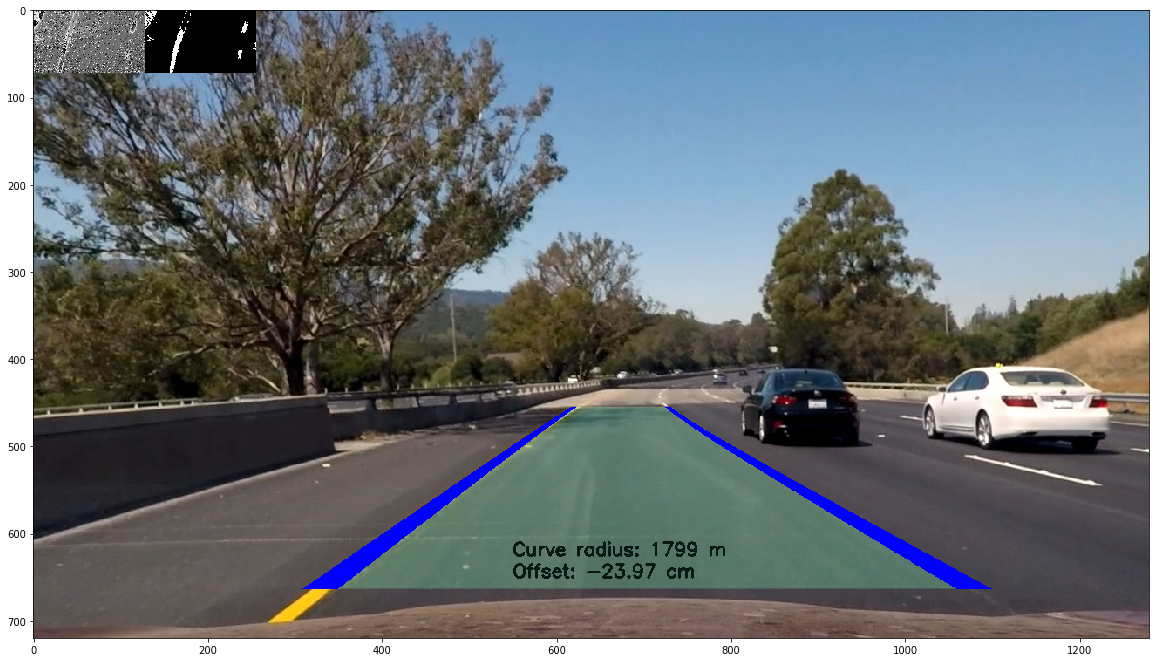

In [27]:
img = undistort(cv2.imread(os.path.join(os.getcwd(), test_images_path, 'test6.jpg')))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
lines = {'left': Line(), 'right':Line()}
plt.imshow(process_video(img))

In [28]:
lines = {'left': Line(), 'right':Line()}
write_output = 'video_output2.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

(720, 1280)
[MoviePy] >>>> Building video video_output2.mp4
[MoviePy] Writing video video_output2.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

(720, 1280)


  0%|                                         | 1/1261 [00:01<28:13,  1.34s/it]

(720, 1280)


  0%|                                         | 2/1261 [00:02<28:14,  1.35s/it]

(720, 1280)


  0%|                                         | 3/1261 [00:04<28:15,  1.35s/it]

(720, 1280)


  0%|▏                                        | 4/1261 [00:05<28:13,  1.35s/it]

(720, 1280)


  0%|▏                                        | 5/1261 [00:06<28:13,  1.35s/it]

(720, 1280)


  0%|▏                                        | 6/1261 [00:08<28:08,  1.35s/it]

(720, 1280)


  1%|▏                                        | 7/1261 [00:09<28:08,  1.35s/it]

(720, 1280)


  1%|▎                                        | 8/1261 [00:10<27:57,  1.34s/it]

(720, 1280)


  1%|▎                                        | 9/1261 [00:12<27:52,  1.34s/it]

(720, 1280)


  1%|▎                                       | 10/1261 [00:13<27:46,  1.33s/it]

(720, 1280)


  1%|▎                                       | 11/1261 [00:14<28:01,  1.35s/it]

(720, 1280)


  1%|▍                                       | 12/1261 [00:16<27:58,  1.34s/it]

(720, 1280)


  1%|▍                                       | 13/1261 [00:17<27:50,  1.34s/it]

(720, 1280)


  1%|▍                                       | 14/1261 [00:18<27:49,  1.34s/it]

(720, 1280)


  1%|▍                                       | 15/1261 [00:20<27:51,  1.34s/it]

(720, 1280)


  1%|▌                                       | 16/1261 [00:21<27:52,  1.34s/it]

(720, 1280)


  1%|▌                                       | 17/1261 [00:22<27:53,  1.35s/it]

(720, 1280)


  1%|▌                                       | 18/1261 [00:24<27:57,  1.35s/it]

(720, 1280)


  2%|▌                                       | 19/1261 [00:25<27:47,  1.34s/it]

(720, 1280)


  2%|▋                                       | 20/1261 [00:27<28:40,  1.39s/it]

(720, 1280)


  2%|▋                                       | 21/1261 [00:28<29:14,  1.41s/it]

(720, 1280)


  2%|▋                                       | 22/1261 [00:29<29:43,  1.44s/it]

(720, 1280)


  2%|▋                                       | 23/1261 [00:31<29:21,  1.42s/it]

(720, 1280)


  2%|▊                                       | 24/1261 [00:32<29:06,  1.41s/it]

(720, 1280)


  2%|▊                                       | 25/1261 [00:34<29:24,  1.43s/it]

(720, 1280)


  2%|▊                                       | 26/1261 [00:35<30:14,  1.47s/it]

(720, 1280)


  2%|▊                                       | 27/1261 [00:37<29:37,  1.44s/it]

(720, 1280)


  2%|▉                                       | 28/1261 [00:38<29:06,  1.42s/it]

(720, 1280)


  2%|▉                                       | 29/1261 [00:39<29:12,  1.42s/it]

(720, 1280)


  2%|▉                                       | 30/1261 [00:41<29:01,  1.41s/it]

(720, 1280)


  2%|▉                                       | 31/1261 [00:42<28:59,  1.41s/it]

(720, 1280)


  3%|█                                       | 32/1261 [00:44<28:54,  1.41s/it]

(720, 1280)


  3%|█                                       | 33/1261 [00:45<28:46,  1.41s/it]

(720, 1280)


  3%|█                                       | 34/1261 [00:46<28:49,  1.41s/it]

(720, 1280)


  3%|█                                       | 35/1261 [00:48<28:42,  1.40s/it]

(720, 1280)


  3%|█▏                                      | 36/1261 [00:49<28:33,  1.40s/it]

(720, 1280)


  3%|█▏                                      | 37/1261 [00:51<28:17,  1.39s/it]

(720, 1280)


  3%|█▏                                      | 38/1261 [00:52<28:07,  1.38s/it]

(720, 1280)


  3%|█▏                                      | 39/1261 [00:53<27:55,  1.37s/it]

(720, 1280)


  3%|█▎                                      | 40/1261 [00:55<28:04,  1.38s/it]

(720, 1280)


  3%|█▎                                      | 41/1261 [00:56<28:30,  1.40s/it]

(720, 1280)


  3%|█▎                                      | 42/1261 [00:58<29:17,  1.44s/it]

(720, 1280)


  3%|█▎                                      | 43/1261 [00:59<29:45,  1.47s/it]

(720, 1280)


  3%|█▍                                      | 44/1261 [01:01<30:20,  1.50s/it]

(720, 1280)


  4%|█▍                                      | 45/1261 [01:02<31:02,  1.53s/it]

(720, 1280)


  4%|█▍                                      | 46/1261 [01:04<31:52,  1.57s/it]

(720, 1280)


  4%|█▍                                      | 47/1261 [01:06<31:41,  1.57s/it]

(720, 1280)


  4%|█▌                                      | 48/1261 [01:07<30:40,  1.52s/it]

(720, 1280)


  4%|█▌                                      | 49/1261 [01:09<30:16,  1.50s/it]

(720, 1280)


  4%|█▌                                      | 50/1261 [01:10<29:35,  1.47s/it]

(720, 1280)


  4%|█▌                                      | 51/1261 [01:11<29:07,  1.44s/it]

(720, 1280)


  4%|█▋                                      | 52/1261 [01:13<28:33,  1.42s/it]

(720, 1280)


  4%|█▋                                      | 53/1261 [01:14<28:19,  1.41s/it]

(720, 1280)


  4%|█▋                                      | 54/1261 [01:15<28:29,  1.42s/it]

(720, 1280)


  4%|█▋                                      | 55/1261 [01:17<28:17,  1.41s/it]

(720, 1280)


  4%|█▊                                      | 56/1261 [01:18<28:11,  1.40s/it]

(720, 1280)


  5%|█▊                                      | 57/1261 [01:20<28:08,  1.40s/it]

(720, 1280)


  5%|█▊                                      | 58/1261 [01:21<28:04,  1.40s/it]

(720, 1280)


  5%|█▊                                      | 59/1261 [01:22<28:17,  1.41s/it]

(720, 1280)


  5%|█▉                                      | 60/1261 [01:24<28:12,  1.41s/it]

(720, 1280)


  5%|█▉                                      | 61/1261 [01:25<28:00,  1.40s/it]

(720, 1280)


  5%|█▉                                      | 62/1261 [01:27<27:56,  1.40s/it]

(720, 1280)


  5%|█▉                                      | 63/1261 [01:28<27:54,  1.40s/it]

(720, 1280)


  5%|██                                      | 64/1261 [01:29<27:51,  1.40s/it]

(720, 1280)


  5%|██                                      | 65/1261 [01:31<27:51,  1.40s/it]

(720, 1280)


  5%|██                                      | 66/1261 [01:32<28:14,  1.42s/it]

(720, 1280)


  5%|██▏                                     | 67/1261 [01:34<28:21,  1.43s/it]

(720, 1280)


  5%|██▏                                     | 68/1261 [01:35<28:22,  1.43s/it]

(720, 1280)


  5%|██▏                                     | 69/1261 [01:37<28:19,  1.43s/it]

(720, 1280)


  6%|██▏                                     | 70/1261 [01:38<28:05,  1.42s/it]

(720, 1280)


  6%|██▎                                     | 71/1261 [01:39<27:57,  1.41s/it]

(720, 1280)


  6%|██▎                                     | 72/1261 [01:41<27:50,  1.41s/it]

(720, 1280)


  6%|██▎                                     | 73/1261 [01:42<27:43,  1.40s/it]

(720, 1280)


  6%|██▎                                     | 74/1261 [01:44<27:55,  1.41s/it]

(720, 1280)


  6%|██▍                                     | 75/1261 [01:45<28:03,  1.42s/it]

(720, 1280)


  6%|██▍                                     | 76/1261 [01:46<28:08,  1.43s/it]

(720, 1280)


  6%|██▍                                     | 77/1261 [01:48<27:50,  1.41s/it]

(720, 1280)


  6%|██▍                                     | 78/1261 [01:49<27:36,  1.40s/it]

(720, 1280)


  6%|██▌                                     | 79/1261 [01:51<27:36,  1.40s/it]

(720, 1280)


  6%|██▌                                     | 80/1261 [01:52<27:26,  1.39s/it]

(720, 1280)


  6%|██▌                                     | 81/1261 [01:53<27:25,  1.39s/it]

(720, 1280)


  7%|██▌                                     | 82/1261 [01:55<28:33,  1.45s/it]

(720, 1280)


  7%|██▋                                     | 83/1261 [01:57<28:53,  1.47s/it]

(720, 1280)


  7%|██▋                                     | 84/1261 [01:58<28:14,  1.44s/it]

(720, 1280)


  7%|██▋                                     | 85/1261 [01:59<28:11,  1.44s/it]

(720, 1280)


  7%|██▋                                     | 86/1261 [02:01<27:50,  1.42s/it]

(720, 1280)


  7%|██▊                                     | 87/1261 [02:02<27:25,  1.40s/it]

(720, 1280)


  7%|██▊                                     | 88/1261 [02:03<27:16,  1.40s/it]

(720, 1280)


  7%|██▊                                     | 89/1261 [02:05<27:09,  1.39s/it]

(720, 1280)


  7%|██▊                                     | 90/1261 [02:06<26:48,  1.37s/it]

(720, 1280)


  7%|██▉                                     | 91/1261 [02:08<27:00,  1.38s/it]

(720, 1280)


  7%|██▉                                     | 92/1261 [02:09<27:12,  1.40s/it]

(720, 1280)


  7%|██▉                                     | 93/1261 [02:10<26:53,  1.38s/it]

(720, 1280)


  7%|██▉                                     | 94/1261 [02:12<27:36,  1.42s/it]

(720, 1280)


  8%|███                                     | 95/1261 [02:13<27:38,  1.42s/it]

(720, 1280)


  8%|███                                     | 96/1261 [02:15<27:50,  1.43s/it]

(720, 1280)


  8%|███                                     | 97/1261 [02:16<27:36,  1.42s/it]

(720, 1280)


  8%|███                                     | 98/1261 [02:18<28:02,  1.45s/it]

(720, 1280)


  8%|███▏                                    | 99/1261 [02:19<27:44,  1.43s/it]

(720, 1280)


  8%|███                                    | 100/1261 [02:20<27:32,  1.42s/it]

(720, 1280)


  8%|███                                    | 101/1261 [02:22<27:33,  1.43s/it]

(720, 1280)


  8%|███▏                                   | 102/1261 [02:23<27:39,  1.43s/it]

(720, 1280)


  8%|███▏                                   | 103/1261 [02:25<27:47,  1.44s/it]

(720, 1280)


  8%|███▏                                   | 104/1261 [02:26<27:37,  1.43s/it]

(720, 1280)


  8%|███▏                                   | 105/1261 [02:28<27:40,  1.44s/it]

(720, 1280)


  8%|███▎                                   | 106/1261 [02:29<27:57,  1.45s/it]

(720, 1280)


  8%|███▎                                   | 107/1261 [02:31<29:22,  1.53s/it]

(720, 1280)


  9%|███▎                                   | 108/1261 [02:32<29:01,  1.51s/it]

(720, 1280)


  9%|███▎                                   | 109/1261 [02:34<28:35,  1.49s/it]

(720, 1280)


  9%|███▍                                   | 110/1261 [02:35<28:41,  1.50s/it]

(720, 1280)


  9%|███▍                                   | 111/1261 [02:37<29:04,  1.52s/it]

(720, 1280)


  9%|███▍                                   | 112/1261 [02:38<28:53,  1.51s/it]

(720, 1280)


  9%|███▍                                   | 113/1261 [02:40<28:31,  1.49s/it]

(720, 1280)


  9%|███▌                                   | 114/1261 [02:41<28:29,  1.49s/it]

(720, 1280)


  9%|███▌                                   | 115/1261 [02:43<28:20,  1.48s/it]

(720, 1280)


  9%|███▌                                   | 116/1261 [02:44<28:36,  1.50s/it]

(720, 1280)


  9%|███▌                                   | 117/1261 [02:46<28:12,  1.48s/it]

(720, 1280)


  9%|███▋                                   | 118/1261 [02:47<29:09,  1.53s/it]

(720, 1280)


  9%|███▋                                   | 119/1261 [02:49<28:13,  1.48s/it]

(720, 1280)


 10%|███▋                                   | 120/1261 [02:50<28:04,  1.48s/it]

(720, 1280)


 10%|███▋                                   | 121/1261 [02:52<27:58,  1.47s/it]

(720, 1280)


 10%|███▊                                   | 122/1261 [02:53<27:52,  1.47s/it]

(720, 1280)


 10%|███▊                                   | 123/1261 [02:55<27:33,  1.45s/it]

(720, 1280)


 10%|███▊                                   | 124/1261 [02:56<27:19,  1.44s/it]

(720, 1280)


 10%|███▊                                   | 125/1261 [02:57<27:31,  1.45s/it]

(720, 1280)


 10%|███▉                                   | 126/1261 [02:59<27:33,  1.46s/it]

(720, 1280)


 10%|███▉                                   | 127/1261 [03:00<27:41,  1.47s/it]

(720, 1280)


 10%|███▉                                   | 128/1261 [03:02<27:57,  1.48s/it]

(720, 1280)


 10%|███▉                                   | 129/1261 [03:03<27:48,  1.47s/it]

(720, 1280)


 10%|████                                   | 130/1261 [03:05<28:17,  1.50s/it]

(720, 1280)


 10%|████                                   | 131/1261 [03:06<28:31,  1.51s/it]

(720, 1280)


 10%|████                                   | 132/1261 [03:08<28:33,  1.52s/it]

(720, 1280)


 11%|████                                   | 133/1261 [03:09<28:25,  1.51s/it]

(720, 1280)


 11%|████▏                                  | 134/1261 [03:11<28:13,  1.50s/it]

(720, 1280)


 11%|████▏                                  | 135/1261 [03:12<28:12,  1.50s/it]

(720, 1280)


 11%|████▏                                  | 136/1261 [03:14<28:07,  1.50s/it]

(720, 1280)


 11%|████▏                                  | 137/1261 [03:15<28:08,  1.50s/it]

(720, 1280)


 11%|████▎                                  | 138/1261 [03:17<27:54,  1.49s/it]

(720, 1280)


 11%|████▎                                  | 139/1261 [03:18<27:40,  1.48s/it]

(720, 1280)


 11%|████▎                                  | 140/1261 [03:20<27:18,  1.46s/it]

(720, 1280)


 11%|████▎                                  | 141/1261 [03:21<26:57,  1.44s/it]

(720, 1280)


 11%|████▍                                  | 142/1261 [03:23<27:32,  1.48s/it]

(720, 1280)


 11%|████▍                                  | 143/1261 [03:24<27:45,  1.49s/it]

(720, 1280)


 11%|████▍                                  | 144/1261 [03:26<28:55,  1.55s/it]

(720, 1280)


 11%|████▍                                  | 145/1261 [03:27<28:20,  1.52s/it]

(720, 1280)


 12%|████▌                                  | 146/1261 [03:29<28:00,  1.51s/it]

(720, 1280)


 12%|████▌                                  | 147/1261 [03:30<27:36,  1.49s/it]

(720, 1280)


 12%|████▌                                  | 148/1261 [03:32<27:19,  1.47s/it]

(720, 1280)


 12%|████▌                                  | 149/1261 [03:33<27:15,  1.47s/it]

(720, 1280)


 12%|████▋                                  | 150/1261 [03:35<26:54,  1.45s/it]

(720, 1280)


 12%|████▋                                  | 151/1261 [03:36<26:38,  1.44s/it]

(720, 1280)


 12%|████▋                                  | 152/1261 [03:38<27:33,  1.49s/it]

(720, 1280)


 12%|████▋                                  | 153/1261 [03:39<28:52,  1.56s/it]

(720, 1280)


 12%|████▊                                  | 154/1261 [03:41<28:15,  1.53s/it]

(720, 1280)


 12%|████▊                                  | 155/1261 [03:42<27:45,  1.51s/it]

(720, 1280)


 12%|████▊                                  | 156/1261 [03:44<27:19,  1.48s/it]

(720, 1280)


 12%|████▊                                  | 157/1261 [03:45<26:50,  1.46s/it]

(720, 1280)


 13%|████▉                                  | 158/1261 [03:47<26:41,  1.45s/it]

(720, 1280)


 13%|████▉                                  | 159/1261 [03:48<26:38,  1.45s/it]

(720, 1280)


 13%|████▉                                  | 160/1261 [03:49<26:32,  1.45s/it]

(720, 1280)


 13%|████▉                                  | 161/1261 [03:51<26:27,  1.44s/it]

(720, 1280)


 13%|█████                                  | 162/1261 [03:52<26:16,  1.43s/it]

(720, 1280)


 13%|█████                                  | 163/1261 [03:54<26:10,  1.43s/it]

(720, 1280)


 13%|█████                                  | 164/1261 [03:55<26:05,  1.43s/it]

(720, 1280)


 13%|█████                                  | 165/1261 [03:57<26:05,  1.43s/it]

(720, 1280)


 13%|█████▏                                 | 166/1261 [03:58<26:01,  1.43s/it]

(720, 1280)


 13%|█████▏                                 | 167/1261 [03:59<26:10,  1.44s/it]

(720, 1280)


 13%|█████▏                                 | 168/1261 [04:01<26:05,  1.43s/it]

(720, 1280)


 13%|█████▏                                 | 169/1261 [04:02<25:59,  1.43s/it]

(720, 1280)


 13%|█████▎                                 | 170/1261 [04:04<25:59,  1.43s/it]

(720, 1280)


 14%|█████▎                                 | 171/1261 [04:05<25:55,  1.43s/it]

(720, 1280)


 14%|█████▎                                 | 172/1261 [04:07<25:51,  1.42s/it]

(720, 1280)


 14%|█████▎                                 | 173/1261 [04:08<25:48,  1.42s/it]

(720, 1280)


 14%|█████▍                                 | 174/1261 [04:09<25:46,  1.42s/it]

(720, 1280)


 14%|█████▍                                 | 175/1261 [04:11<25:37,  1.42s/it]

(720, 1280)


 14%|█████▍                                 | 176/1261 [04:12<25:37,  1.42s/it]

(720, 1280)


 14%|█████▍                                 | 177/1261 [04:14<25:43,  1.42s/it]

(720, 1280)


 14%|█████▌                                 | 178/1261 [04:15<25:45,  1.43s/it]

(720, 1280)


 14%|█████▌                                 | 179/1261 [04:17<25:45,  1.43s/it]

(720, 1280)


 14%|█████▌                                 | 180/1261 [04:18<25:40,  1.43s/it]

(720, 1280)


 14%|█████▌                                 | 181/1261 [04:19<25:36,  1.42s/it]

(720, 1280)


 14%|█████▋                                 | 182/1261 [04:21<25:34,  1.42s/it]

(720, 1280)


 15%|█████▋                                 | 183/1261 [04:22<25:33,  1.42s/it]

(720, 1280)


 15%|█████▋                                 | 184/1261 [04:24<25:31,  1.42s/it]

(720, 1280)


 15%|█████▋                                 | 185/1261 [04:25<25:33,  1.42s/it]

(720, 1280)


 15%|█████▊                                 | 186/1261 [04:26<25:25,  1.42s/it]

(720, 1280)


 15%|█████▊                                 | 187/1261 [04:28<25:19,  1.42s/it]

(720, 1280)


 15%|█████▊                                 | 188/1261 [04:29<25:20,  1.42s/it]

(720, 1280)


 15%|█████▊                                 | 189/1261 [04:31<25:18,  1.42s/it]

(720, 1280)


 15%|█████▉                                 | 190/1261 [04:32<25:15,  1.41s/it]

(720, 1280)


 15%|█████▉                                 | 191/1261 [04:34<25:25,  1.43s/it]

(720, 1280)


 15%|█████▉                                 | 192/1261 [04:35<25:41,  1.44s/it]

(720, 1280)


 15%|█████▉                                 | 193/1261 [04:37<25:43,  1.45s/it]

(720, 1280)


 15%|██████                                 | 194/1261 [04:38<25:39,  1.44s/it]

(720, 1280)


 15%|██████                                 | 195/1261 [04:39<25:39,  1.44s/it]

(720, 1280)


 16%|██████                                 | 196/1261 [04:41<25:27,  1.43s/it]

(720, 1280)


 16%|██████                                 | 197/1261 [04:42<25:22,  1.43s/it]

(720, 1280)


 16%|██████                                 | 198/1261 [04:44<25:46,  1.45s/it]

(720, 1280)


 16%|██████▏                                | 199/1261 [04:45<25:59,  1.47s/it]

(720, 1280)


 16%|██████▏                                | 200/1261 [04:47<25:49,  1.46s/it]

(720, 1280)


 16%|██████▏                                | 201/1261 [04:48<25:40,  1.45s/it]

(720, 1280)


 16%|██████▏                                | 202/1261 [04:50<25:47,  1.46s/it]

(720, 1280)


 16%|██████▎                                | 203/1261 [04:51<25:29,  1.45s/it]

(720, 1280)


 16%|██████▎                                | 204/1261 [04:53<25:54,  1.47s/it]

(720, 1280)


 16%|██████▎                                | 205/1261 [04:54<25:34,  1.45s/it]

(720, 1280)


 16%|██████▎                                | 206/1261 [04:55<25:18,  1.44s/it]

(720, 1280)


 16%|██████▍                                | 207/1261 [04:57<25:10,  1.43s/it]

(720, 1280)


 16%|██████▍                                | 208/1261 [04:58<24:57,  1.42s/it]

(720, 1280)


 17%|██████▍                                | 209/1261 [05:00<24:53,  1.42s/it]

(720, 1280)


 17%|██████▍                                | 210/1261 [05:01<25:18,  1.44s/it]

(720, 1280)


 17%|██████▌                                | 211/1261 [05:03<25:39,  1.47s/it]

(720, 1280)


 17%|██████▌                                | 212/1261 [05:04<26:26,  1.51s/it]

(720, 1280)


 17%|██████▌                                | 213/1261 [05:06<26:15,  1.50s/it]

(720, 1280)


 17%|██████▌                                | 214/1261 [05:07<26:05,  1.50s/it]

(720, 1280)


 17%|██████▋                                | 215/1261 [05:09<25:59,  1.49s/it]

(720, 1280)


 17%|██████▋                                | 216/1261 [05:10<25:46,  1.48s/it]

(720, 1280)


 17%|██████▋                                | 217/1261 [05:12<25:35,  1.47s/it]

(720, 1280)


 17%|██████▋                                | 218/1261 [05:13<25:28,  1.47s/it]

(720, 1280)


 17%|██████▊                                | 219/1261 [05:14<25:21,  1.46s/it]

(720, 1280)


 17%|██████▊                                | 220/1261 [05:16<25:13,  1.45s/it]

(720, 1280)


 18%|██████▊                                | 221/1261 [05:17<25:06,  1.45s/it]

(720, 1280)


 18%|██████▊                                | 222/1261 [05:19<25:06,  1.45s/it]

(720, 1280)


 18%|██████▉                                | 223/1261 [05:20<25:02,  1.45s/it]

(720, 1280)


 18%|██████▉                                | 224/1261 [05:22<25:00,  1.45s/it]

(720, 1280)


 18%|██████▉                                | 225/1261 [05:23<25:00,  1.45s/it]

(720, 1280)


 18%|██████▉                                | 226/1261 [05:25<24:59,  1.45s/it]

(720, 1280)


 18%|███████                                | 227/1261 [05:26<24:57,  1.45s/it]

(720, 1280)


 18%|███████                                | 228/1261 [05:28<25:14,  1.47s/it]

(720, 1280)


 18%|███████                                | 229/1261 [05:29<25:26,  1.48s/it]

(720, 1280)


 18%|███████                                | 230/1261 [05:31<25:59,  1.51s/it]

(720, 1280)


 18%|███████▏                               | 231/1261 [05:32<25:39,  1.49s/it]

(720, 1280)


 18%|███████▏                               | 232/1261 [05:34<25:26,  1.48s/it]

(720, 1280)


 18%|███████▏                               | 233/1261 [05:35<25:40,  1.50s/it]

(720, 1280)


 19%|███████▏                               | 234/1261 [05:37<26:19,  1.54s/it]

(720, 1280)


 19%|███████▎                               | 235/1261 [05:38<26:24,  1.54s/it]

(720, 1280)


 19%|███████▎                               | 236/1261 [05:40<26:38,  1.56s/it]

(720, 1280)


 19%|███████▎                               | 237/1261 [05:41<26:31,  1.55s/it]

(720, 1280)


 19%|███████▎                               | 238/1261 [05:43<26:07,  1.53s/it]

(720, 1280)


 19%|███████▍                               | 239/1261 [05:44<25:38,  1.51s/it]

(720, 1280)


 19%|███████▍                               | 240/1261 [05:46<25:42,  1.51s/it]

(720, 1280)


 19%|███████▍                               | 241/1261 [05:47<25:15,  1.49s/it]

(720, 1280)


 19%|███████▍                               | 242/1261 [05:49<24:57,  1.47s/it]

(720, 1280)


 19%|███████▌                               | 243/1261 [05:50<24:50,  1.46s/it]

(720, 1280)


 19%|███████▌                               | 244/1261 [05:52<24:57,  1.47s/it]

(720, 1280)


 19%|███████▌                               | 245/1261 [05:53<24:50,  1.47s/it]

(720, 1280)


 20%|███████▌                               | 246/1261 [05:55<25:04,  1.48s/it]

(720, 1280)


 20%|███████▋                               | 247/1261 [05:56<24:43,  1.46s/it]

(720, 1280)


 20%|███████▋                               | 248/1261 [05:57<24:36,  1.46s/it]

(720, 1280)


 20%|███████▋                               | 249/1261 [05:59<24:30,  1.45s/it]

(720, 1280)


 20%|███████▋                               | 250/1261 [06:00<24:41,  1.47s/it]

(720, 1280)


 20%|███████▊                               | 251/1261 [06:02<24:41,  1.47s/it]

(720, 1280)


 20%|███████▊                               | 252/1261 [06:03<24:26,  1.45s/it]

(720, 1280)


 20%|███████▊                               | 253/1261 [06:05<24:21,  1.45s/it]

(720, 1280)


 20%|███████▊                               | 254/1261 [06:06<24:16,  1.45s/it]

(720, 1280)


 20%|███████▉                               | 255/1261 [06:08<24:10,  1.44s/it]

(720, 1280)


 20%|███████▉                               | 256/1261 [06:09<24:16,  1.45s/it]

(720, 1280)


 20%|███████▉                               | 257/1261 [06:11<24:24,  1.46s/it]

(720, 1280)


 20%|███████▉                               | 258/1261 [06:12<24:11,  1.45s/it]

(720, 1280)


 21%|████████                               | 259/1261 [06:13<24:06,  1.44s/it]

(720, 1280)


 21%|████████                               | 260/1261 [06:15<25:07,  1.51s/it]

(720, 1280)


 21%|████████                               | 261/1261 [06:17<24:59,  1.50s/it]

(720, 1280)


 21%|████████                               | 262/1261 [06:18<24:41,  1.48s/it]

(720, 1280)


 21%|████████▏                              | 263/1261 [06:19<24:35,  1.48s/it]

(720, 1280)


 21%|████████▏                              | 264/1261 [06:21<24:21,  1.47s/it]

(720, 1280)


 21%|████████▏                              | 265/1261 [06:22<24:08,  1.45s/it]

(720, 1280)


 21%|████████▏                              | 266/1261 [06:24<24:00,  1.45s/it]

(720, 1280)


 21%|████████▎                              | 267/1261 [06:25<23:58,  1.45s/it]

(720, 1280)


 21%|████████▎                              | 268/1261 [06:27<23:55,  1.45s/it]

(720, 1280)


 21%|████████▎                              | 269/1261 [06:28<24:11,  1.46s/it]

(720, 1280)


 21%|████████▎                              | 270/1261 [06:30<24:12,  1.47s/it]

(720, 1280)


 21%|████████▍                              | 271/1261 [06:31<24:40,  1.50s/it]

(720, 1280)


 22%|████████▍                              | 272/1261 [06:33<24:47,  1.50s/it]

(720, 1280)


 22%|████████▍                              | 273/1261 [06:34<24:56,  1.51s/it]

(720, 1280)


 22%|████████▍                              | 274/1261 [06:36<25:17,  1.54s/it]

(720, 1280)


 22%|████████▌                              | 275/1261 [06:37<24:45,  1.51s/it]

(720, 1280)


 22%|████████▌                              | 276/1261 [06:39<25:26,  1.55s/it]

(720, 1280)


 22%|████████▌                              | 277/1261 [06:40<24:47,  1.51s/it]

(720, 1280)


 22%|████████▌                              | 278/1261 [06:42<24:24,  1.49s/it]

(720, 1280)


 22%|████████▋                              | 279/1261 [06:43<24:27,  1.49s/it]

(720, 1280)


 22%|████████▋                              | 280/1261 [06:45<24:14,  1.48s/it]

(720, 1280)


 22%|████████▋                              | 281/1261 [06:46<24:09,  1.48s/it]

(720, 1280)


 22%|████████▋                              | 282/1261 [06:48<23:52,  1.46s/it]

(720, 1280)


 22%|████████▊                              | 283/1261 [06:49<24:02,  1.48s/it]

(720, 1280)


 23%|████████▊                              | 284/1261 [06:51<23:51,  1.47s/it]

(720, 1280)


 23%|████████▊                              | 285/1261 [06:52<23:56,  1.47s/it]

(720, 1280)


 23%|████████▊                              | 286/1261 [06:54<23:42,  1.46s/it]

(720, 1280)


 23%|████████▉                              | 287/1261 [06:55<23:56,  1.47s/it]

(720, 1280)


 23%|████████▉                              | 288/1261 [06:57<24:02,  1.48s/it]

(720, 1280)


 23%|████████▉                              | 289/1261 [06:58<23:53,  1.47s/it]

(720, 1280)


 23%|████████▉                              | 290/1261 [06:59<23:52,  1.48s/it]

(720, 1280)


 23%|█████████                              | 291/1261 [07:01<23:43,  1.47s/it]

(720, 1280)


 23%|█████████                              | 292/1261 [07:02<23:26,  1.45s/it]

(720, 1280)


 23%|█████████                              | 293/1261 [07:04<23:52,  1.48s/it]

(720, 1280)


 23%|█████████                              | 294/1261 [07:05<23:41,  1.47s/it]

(720, 1280)


 23%|█████████                              | 295/1261 [07:07<23:41,  1.47s/it]

(720, 1280)


 23%|█████████▏                             | 296/1261 [07:08<23:59,  1.49s/it]

(720, 1280)


 24%|█████████▏                             | 297/1261 [07:10<23:44,  1.48s/it]

(720, 1280)


 24%|█████████▏                             | 298/1261 [07:11<23:32,  1.47s/it]

(720, 1280)


 24%|█████████▏                             | 299/1261 [07:13<23:24,  1.46s/it]

(720, 1280)


 24%|█████████▎                             | 300/1261 [07:14<23:12,  1.45s/it]

(720, 1280)


 24%|█████████▎                             | 301/1261 [07:16<23:04,  1.44s/it]

(720, 1280)


 24%|█████████▎                             | 302/1261 [07:17<22:58,  1.44s/it]

(720, 1280)


 24%|█████████▎                             | 303/1261 [07:18<22:46,  1.43s/it]

(720, 1280)


 24%|█████████▍                             | 304/1261 [07:20<22:53,  1.43s/it]

(720, 1280)


 24%|█████████▍                             | 305/1261 [07:21<22:46,  1.43s/it]

(720, 1280)


 24%|█████████▍                             | 306/1261 [07:23<22:45,  1.43s/it]

(720, 1280)


 24%|█████████▍                             | 307/1261 [07:24<22:43,  1.43s/it]

(720, 1280)


 24%|█████████▌                             | 308/1261 [07:26<22:44,  1.43s/it]

(720, 1280)


 25%|█████████▌                             | 309/1261 [07:27<23:08,  1.46s/it]

(720, 1280)


 25%|█████████▌                             | 310/1261 [07:29<23:09,  1.46s/it]

(720, 1280)


 25%|█████████▌                             | 311/1261 [07:30<23:18,  1.47s/it]

(720, 1280)


 25%|█████████▋                             | 312/1261 [07:31<23:13,  1.47s/it]

(720, 1280)


 25%|█████████▋                             | 313/1261 [07:33<22:55,  1.45s/it]

(720, 1280)


 25%|█████████▋                             | 314/1261 [07:34<22:44,  1.44s/it]

(720, 1280)


 25%|█████████▋                             | 315/1261 [07:36<22:30,  1.43s/it]

(720, 1280)


 25%|█████████▊                             | 316/1261 [07:37<22:25,  1.42s/it]

(720, 1280)


 25%|█████████▊                             | 317/1261 [07:39<22:18,  1.42s/it]

(720, 1280)


 25%|█████████▊                             | 318/1261 [07:40<22:12,  1.41s/it]

(720, 1280)


 25%|█████████▊                             | 319/1261 [07:41<22:14,  1.42s/it]

(720, 1280)


 25%|█████████▉                             | 320/1261 [07:43<22:14,  1.42s/it]

(720, 1280)


 25%|█████████▉                             | 321/1261 [07:44<22:08,  1.41s/it]

(720, 1280)


 26%|█████████▉                             | 322/1261 [07:46<22:05,  1.41s/it]

(720, 1280)


 26%|█████████▉                             | 323/1261 [07:47<22:00,  1.41s/it]

(720, 1280)


 26%|██████████                             | 324/1261 [07:48<22:15,  1.43s/it]

(720, 1280)


 26%|██████████                             | 325/1261 [07:50<22:24,  1.44s/it]

(720, 1280)


 26%|██████████                             | 326/1261 [07:51<22:59,  1.48s/it]

(720, 1280)


 26%|██████████                             | 327/1261 [07:53<23:00,  1.48s/it]

(720, 1280)


 26%|██████████▏                            | 328/1261 [07:54<23:03,  1.48s/it]

(720, 1280)


 26%|██████████▏                            | 329/1261 [07:56<22:57,  1.48s/it]

(720, 1280)


 26%|██████████▏                            | 330/1261 [07:57<22:44,  1.47s/it]

(720, 1280)


 26%|██████████▏                            | 331/1261 [07:59<22:27,  1.45s/it]

(720, 1280)


 26%|██████████▎                            | 332/1261 [08:00<22:13,  1.44s/it]

(720, 1280)


 26%|██████████▎                            | 333/1261 [08:02<22:19,  1.44s/it]

(720, 1280)


 26%|██████████▎                            | 334/1261 [08:03<22:10,  1.43s/it]

(720, 1280)


 27%|██████████▎                            | 335/1261 [08:04<22:01,  1.43s/it]

(720, 1280)


 27%|██████████▍                            | 336/1261 [08:06<21:56,  1.42s/it]

(720, 1280)


 27%|██████████▍                            | 337/1261 [08:07<21:51,  1.42s/it]

(720, 1280)


 27%|██████████▍                            | 338/1261 [08:09<21:48,  1.42s/it]

(720, 1280)


 27%|██████████▍                            | 339/1261 [08:10<21:48,  1.42s/it]

(720, 1280)


 27%|██████████▌                            | 340/1261 [08:11<21:37,  1.41s/it]

(720, 1280)


 27%|██████████▌                            | 341/1261 [08:13<21:37,  1.41s/it]

(720, 1280)


 27%|██████████▌                            | 342/1261 [08:14<21:38,  1.41s/it]

(720, 1280)


 27%|██████████▌                            | 343/1261 [08:16<22:00,  1.44s/it]

(720, 1280)


 27%|██████████▋                            | 344/1261 [08:17<21:58,  1.44s/it]

(720, 1280)


 27%|██████████▋                            | 345/1261 [08:19<22:08,  1.45s/it]

(720, 1280)


 27%|██████████▋                            | 346/1261 [08:20<21:52,  1.43s/it]

(720, 1280)


 28%|██████████▋                            | 347/1261 [08:22<21:43,  1.43s/it]

(720, 1280)


 28%|██████████▊                            | 348/1261 [08:23<21:54,  1.44s/it]

(720, 1280)


 28%|██████████▊                            | 349/1261 [08:24<21:48,  1.43s/it]

(720, 1280)


 28%|██████████▊                            | 350/1261 [08:26<21:39,  1.43s/it]

(720, 1280)


 28%|██████████▊                            | 351/1261 [08:27<21:35,  1.42s/it]

(720, 1280)


 28%|██████████▉                            | 352/1261 [08:29<22:00,  1.45s/it]

(720, 1280)


 28%|██████████▉                            | 353/1261 [08:30<21:48,  1.44s/it]

(720, 1280)


 28%|██████████▉                            | 354/1261 [08:32<21:42,  1.44s/it]

(720, 1280)


 28%|██████████▉                            | 355/1261 [08:33<21:31,  1.43s/it]

(720, 1280)


 28%|███████████                            | 356/1261 [08:34<21:27,  1.42s/it]

(720, 1280)


 28%|███████████                            | 357/1261 [08:36<21:18,  1.41s/it]

(720, 1280)


 28%|███████████                            | 358/1261 [08:37<21:27,  1.43s/it]

(720, 1280)


 28%|███████████                            | 359/1261 [08:39<21:54,  1.46s/it]

(720, 1280)


 29%|███████████▏                           | 360/1261 [08:40<21:43,  1.45s/it]

(720, 1280)


 29%|███████████▏                           | 361/1261 [08:42<21:30,  1.43s/it]

(720, 1280)


 29%|███████████▏                           | 362/1261 [08:43<21:27,  1.43s/it]

(720, 1280)


 29%|███████████▏                           | 363/1261 [08:45<21:53,  1.46s/it]

(720, 1280)


 29%|███████████▎                           | 364/1261 [08:46<21:36,  1.45s/it]

(720, 1280)


 29%|███████████▎                           | 365/1261 [08:47<21:23,  1.43s/it]

(720, 1280)


 29%|███████████▎                           | 366/1261 [08:49<21:12,  1.42s/it]

(720, 1280)


 29%|███████████▎                           | 367/1261 [08:50<21:30,  1.44s/it]

(720, 1280)


 29%|███████████▍                           | 368/1261 [08:52<21:19,  1.43s/it]

(720, 1280)


 29%|███████████▍                           | 369/1261 [08:53<21:13,  1.43s/it]

(720, 1280)


 29%|███████████▍                           | 370/1261 [08:55<21:07,  1.42s/it]

(720, 1280)


 29%|███████████▍                           | 371/1261 [08:56<21:01,  1.42s/it]

(720, 1280)


 30%|███████████▌                           | 372/1261 [08:57<20:58,  1.42s/it]

(720, 1280)


 30%|███████████▌                           | 373/1261 [08:59<20:54,  1.41s/it]

(720, 1280)


 30%|███████████▌                           | 374/1261 [09:00<20:49,  1.41s/it]

(720, 1280)


 30%|███████████▌                           | 375/1261 [09:02<20:56,  1.42s/it]

(720, 1280)


 30%|███████████▋                           | 376/1261 [09:03<21:10,  1.44s/it]

(720, 1280)


 30%|███████████▋                           | 377/1261 [09:05<21:14,  1.44s/it]

(720, 1280)


 30%|███████████▋                           | 378/1261 [09:06<21:41,  1.47s/it]

(720, 1280)


 30%|███████████▋                           | 379/1261 [09:07<21:27,  1.46s/it]

(720, 1280)


 30%|███████████▊                           | 380/1261 [09:09<21:13,  1.45s/it]

(720, 1280)


 30%|███████████▊                           | 381/1261 [09:10<21:01,  1.43s/it]

(720, 1280)


 30%|███████████▊                           | 382/1261 [09:12<20:44,  1.42s/it]

(720, 1280)


 30%|███████████▊                           | 383/1261 [09:13<20:46,  1.42s/it]

(720, 1280)


 30%|███████████▉                           | 384/1261 [09:15<20:45,  1.42s/it]

(720, 1280)


 31%|███████████▉                           | 385/1261 [09:16<20:41,  1.42s/it]

(720, 1280)


 31%|███████████▉                           | 386/1261 [09:17<20:33,  1.41s/it]

(720, 1280)


 31%|███████████▉                           | 387/1261 [09:19<20:33,  1.41s/it]

(720, 1280)


 31%|████████████                           | 388/1261 [09:20<20:54,  1.44s/it]

(720, 1280)


 31%|████████████                           | 389/1261 [09:22<20:43,  1.43s/it]

(720, 1280)


 31%|████████████                           | 390/1261 [09:23<20:33,  1.42s/it]

(720, 1280)


 31%|████████████                           | 391/1261 [09:24<20:25,  1.41s/it]

(720, 1280)


 31%|████████████                           | 392/1261 [09:26<20:19,  1.40s/it]

(720, 1280)


 31%|████████████▏                          | 393/1261 [09:27<20:34,  1.42s/it]

(720, 1280)


 31%|████████████▏                          | 394/1261 [09:29<20:33,  1.42s/it]

(720, 1280)


 31%|████████████▏                          | 395/1261 [09:30<20:29,  1.42s/it]

(720, 1280)


 31%|████████████▏                          | 396/1261 [09:32<20:46,  1.44s/it]

(720, 1280)


 31%|████████████▎                          | 397/1261 [09:33<20:33,  1.43s/it]

(720, 1280)


 32%|████████████▎                          | 398/1261 [09:35<20:46,  1.44s/it]

(720, 1280)


 32%|████████████▎                          | 399/1261 [09:36<20:33,  1.43s/it]

(720, 1280)


 32%|████████████▎                          | 400/1261 [09:37<20:30,  1.43s/it]

(720, 1280)


 32%|████████████▍                          | 401/1261 [09:39<20:46,  1.45s/it]

(720, 1280)


 32%|████████████▍                          | 402/1261 [09:40<20:36,  1.44s/it]

(720, 1280)


 32%|████████████▍                          | 403/1261 [09:42<20:23,  1.43s/it]

(720, 1280)


 32%|████████████▍                          | 404/1261 [09:43<20:17,  1.42s/it]

(720, 1280)


 32%|████████████▌                          | 405/1261 [09:44<20:13,  1.42s/it]

(720, 1280)


 32%|████████████▌                          | 406/1261 [09:46<20:03,  1.41s/it]

(720, 1280)


 32%|████████████▌                          | 407/1261 [09:47<20:07,  1.41s/it]

(720, 1280)


 32%|████████████▌                          | 408/1261 [09:49<20:30,  1.44s/it]

(720, 1280)


 32%|████████████▋                          | 409/1261 [09:50<20:21,  1.43s/it]

(720, 1280)


 33%|████████████▋                          | 410/1261 [09:52<20:14,  1.43s/it]

(720, 1280)


 33%|████████████▋                          | 411/1261 [09:53<20:23,  1.44s/it]

(720, 1280)


 33%|████████████▋                          | 412/1261 [09:54<20:18,  1.43s/it]

(720, 1280)


 33%|████████████▊                          | 413/1261 [09:56<20:09,  1.43s/it]

(720, 1280)


 33%|████████████▊                          | 414/1261 [09:57<20:20,  1.44s/it]

(720, 1280)


 33%|████████████▊                          | 415/1261 [09:59<20:22,  1.45s/it]

(720, 1280)


 33%|████████████▊                          | 416/1261 [10:00<20:07,  1.43s/it]

(720, 1280)


 33%|████████████▉                          | 417/1261 [10:02<20:03,  1.43s/it]

(720, 1280)


 33%|████████████▉                          | 418/1261 [10:03<19:54,  1.42s/it]

(720, 1280)


 33%|████████████▉                          | 419/1261 [10:04<19:51,  1.42s/it]

(720, 1280)


 33%|████████████▉                          | 420/1261 [10:06<20:01,  1.43s/it]

(720, 1280)


 33%|█████████████                          | 421/1261 [10:07<20:11,  1.44s/it]

(720, 1280)


 33%|█████████████                          | 422/1261 [10:09<20:00,  1.43s/it]

(720, 1280)


 34%|█████████████                          | 423/1261 [10:10<20:16,  1.45s/it]

(720, 1280)


 34%|█████████████                          | 424/1261 [10:12<20:00,  1.43s/it]

(720, 1280)


 34%|█████████████▏                         | 425/1261 [10:13<20:00,  1.44s/it]

(720, 1280)


 34%|█████████████▏                         | 426/1261 [10:15<19:55,  1.43s/it]

(720, 1280)


 34%|█████████████▏                         | 427/1261 [10:16<19:50,  1.43s/it]

(720, 1280)


 34%|█████████████▏                         | 428/1261 [10:17<19:57,  1.44s/it]

(720, 1280)


 34%|█████████████▎                         | 429/1261 [10:19<19:56,  1.44s/it]

(720, 1280)


 34%|█████████████▎                         | 430/1261 [10:20<20:10,  1.46s/it]

(720, 1280)


 34%|█████████████▎                         | 431/1261 [10:22<19:52,  1.44s/it]

(720, 1280)


 34%|█████████████▎                         | 432/1261 [10:23<19:38,  1.42s/it]

(720, 1280)


 34%|█████████████▍                         | 433/1261 [10:25<19:38,  1.42s/it]

(720, 1280)


 34%|█████████████▍                         | 434/1261 [10:26<19:28,  1.41s/it]

(720, 1280)


 34%|█████████████▍                         | 435/1261 [10:27<19:26,  1.41s/it]

(720, 1280)


 35%|█████████████▍                         | 436/1261 [10:29<19:23,  1.41s/it]

(720, 1280)


 35%|█████████████▌                         | 437/1261 [10:30<19:33,  1.42s/it]

(720, 1280)


 35%|█████████████▌                         | 438/1261 [10:32<19:22,  1.41s/it]

(720, 1280)


 35%|█████████████▌                         | 439/1261 [10:33<19:17,  1.41s/it]

(720, 1280)


 35%|█████████████▌                         | 440/1261 [10:34<19:28,  1.42s/it]

(720, 1280)


 35%|█████████████▋                         | 441/1261 [10:36<19:28,  1.43s/it]

(720, 1280)


 35%|█████████████▋                         | 442/1261 [10:37<19:35,  1.44s/it]

(720, 1280)


 35%|█████████████▋                         | 443/1261 [10:39<19:29,  1.43s/it]

(720, 1280)


 35%|█████████████▋                         | 444/1261 [10:40<19:34,  1.44s/it]

(720, 1280)


 35%|█████████████▊                         | 445/1261 [10:42<19:27,  1.43s/it]

(720, 1280)


 35%|█████████████▊                         | 446/1261 [10:43<19:36,  1.44s/it]

(720, 1280)


 35%|█████████████▊                         | 447/1261 [10:45<19:50,  1.46s/it]

(720, 1280)


 36%|█████████████▊                         | 448/1261 [10:46<19:31,  1.44s/it]

(720, 1280)


 36%|█████████████▉                         | 449/1261 [10:47<19:16,  1.42s/it]

(720, 1280)


 36%|█████████████▉                         | 450/1261 [10:49<19:07,  1.42s/it]

(720, 1280)


 36%|█████████████▉                         | 451/1261 [10:50<19:09,  1.42s/it]

(720, 1280)


 36%|█████████████▉                         | 452/1261 [10:52<19:46,  1.47s/it]

(720, 1280)


 36%|██████████████                         | 453/1261 [10:53<19:27,  1.44s/it]

(720, 1280)


 36%|██████████████                         | 454/1261 [10:55<19:13,  1.43s/it]

(720, 1280)


 36%|██████████████                         | 455/1261 [10:56<18:59,  1.41s/it]

(720, 1280)


 36%|██████████████                         | 456/1261 [10:57<18:53,  1.41s/it]

(720, 1280)


 36%|██████████████▏                        | 457/1261 [10:59<18:57,  1.42s/it]

(720, 1280)


 36%|██████████████▏                        | 458/1261 [11:00<18:48,  1.41s/it]

(720, 1280)


 36%|██████████████▏                        | 459/1261 [11:02<18:46,  1.40s/it]

(720, 1280)


 36%|██████████████▏                        | 460/1261 [11:03<18:41,  1.40s/it]

(720, 1280)


 37%|██████████████▎                        | 461/1261 [11:04<18:59,  1.42s/it]

(720, 1280)


 37%|██████████████▎                        | 462/1261 [11:06<19:05,  1.43s/it]

(720, 1280)


 37%|██████████████▎                        | 463/1261 [11:07<19:04,  1.43s/it]

(720, 1280)


 37%|██████████████▎                        | 464/1261 [11:09<19:38,  1.48s/it]

(720, 1280)


 37%|██████████████▍                        | 465/1261 [11:10<19:26,  1.47s/it]

(720, 1280)


 37%|██████████████▍                        | 466/1261 [11:12<19:34,  1.48s/it]

(720, 1280)


 37%|██████████████▍                        | 467/1261 [11:13<19:48,  1.50s/it]

(720, 1280)


 37%|██████████████▍                        | 468/1261 [11:15<19:45,  1.49s/it]

(720, 1280)


 37%|██████████████▌                        | 469/1261 [11:16<20:07,  1.52s/it]

(720, 1280)


 37%|██████████████▌                        | 470/1261 [11:18<19:53,  1.51s/it]

(720, 1280)


 37%|██████████████▌                        | 471/1261 [11:19<19:38,  1.49s/it]

(720, 1280)


 37%|██████████████▌                        | 472/1261 [11:21<19:22,  1.47s/it]

(720, 1280)


 38%|██████████████▋                        | 473/1261 [11:22<19:12,  1.46s/it]

(720, 1280)


 38%|██████████████▋                        | 474/1261 [11:24<19:03,  1.45s/it]

(720, 1280)


 38%|██████████████▋                        | 475/1261 [11:25<19:11,  1.47s/it]

(720, 1280)


 38%|██████████████▋                        | 476/1261 [11:27<19:25,  1.49s/it]

(720, 1280)


 38%|██████████████▊                        | 477/1261 [11:28<20:01,  1.53s/it]

(720, 1280)


 38%|██████████████▊                        | 478/1261 [11:30<19:56,  1.53s/it]

(720, 1280)


 38%|██████████████▊                        | 479/1261 [11:31<19:49,  1.52s/it]

(720, 1280)


 38%|██████████████▊                        | 480/1261 [11:33<19:30,  1.50s/it]

(720, 1280)


 38%|██████████████▉                        | 481/1261 [11:34<19:20,  1.49s/it]

(720, 1280)


 38%|██████████████▉                        | 482/1261 [11:36<19:00,  1.46s/it]

(720, 1280)


 38%|██████████████▉                        | 483/1261 [11:37<19:06,  1.47s/it]

(720, 1280)


 38%|██████████████▉                        | 484/1261 [11:39<19:13,  1.48s/it]

(720, 1280)


 38%|███████████████                        | 485/1261 [11:40<19:02,  1.47s/it]

(720, 1280)


 39%|███████████████                        | 486/1261 [11:42<19:14,  1.49s/it]

(720, 1280)


 39%|███████████████                        | 487/1261 [11:43<19:10,  1.49s/it]

(720, 1280)


 39%|███████████████                        | 488/1261 [11:45<18:55,  1.47s/it]

(720, 1280)


 39%|███████████████                        | 489/1261 [11:46<18:55,  1.47s/it]

(720, 1280)


 39%|███████████████▏                       | 490/1261 [11:48<18:48,  1.46s/it]

(720, 1280)


 39%|███████████████▏                       | 491/1261 [11:49<18:42,  1.46s/it]

(720, 1280)


 39%|███████████████▏                       | 492/1261 [11:51<19:03,  1.49s/it]

(720, 1280)


 39%|███████████████▏                       | 493/1261 [11:52<19:04,  1.49s/it]

(720, 1280)


 39%|███████████████▎                       | 494/1261 [11:54<19:02,  1.49s/it]

(720, 1280)


 39%|███████████████▎                       | 495/1261 [11:55<19:08,  1.50s/it]

(720, 1280)


 39%|███████████████▎                       | 496/1261 [11:56<18:58,  1.49s/it]

(720, 1280)


 39%|███████████████▎                       | 497/1261 [11:58<18:56,  1.49s/it]

(720, 1280)


 39%|███████████████▍                       | 498/1261 [11:59<18:51,  1.48s/it]

(720, 1280)


 40%|███████████████▍                       | 499/1261 [12:01<18:47,  1.48s/it]

(720, 1280)


 40%|███████████████▍                       | 500/1261 [12:02<18:40,  1.47s/it]

(720, 1280)


 40%|███████████████▍                       | 501/1261 [12:04<18:41,  1.48s/it]

(720, 1280)


 40%|███████████████▌                       | 502/1261 [12:05<18:39,  1.47s/it]

(720, 1280)


 40%|███████████████▌                       | 503/1261 [12:07<18:35,  1.47s/it]

(720, 1280)


 40%|███████████████▌                       | 504/1261 [12:08<18:37,  1.48s/it]

(720, 1280)


 40%|███████████████▌                       | 505/1261 [12:10<18:34,  1.47s/it]

(720, 1280)


 40%|███████████████▋                       | 506/1261 [12:11<18:33,  1.48s/it]

(720, 1280)


 40%|███████████████▋                       | 507/1261 [12:13<18:59,  1.51s/it]

(720, 1280)


 40%|███████████████▋                       | 508/1261 [12:14<19:05,  1.52s/it]

(720, 1280)


 40%|███████████████▋                       | 509/1261 [12:16<18:52,  1.51s/it]

(720, 1280)


 40%|███████████████▊                       | 510/1261 [12:17<18:43,  1.50s/it]

(720, 1280)


 41%|███████████████▊                       | 511/1261 [12:19<18:31,  1.48s/it]

(720, 1280)


 41%|███████████████▊                       | 512/1261 [12:20<18:19,  1.47s/it]

(720, 1280)


 41%|███████████████▊                       | 513/1261 [12:22<18:08,  1.45s/it]

(720, 1280)


 41%|███████████████▉                       | 514/1261 [12:23<18:11,  1.46s/it]

(720, 1280)


 41%|███████████████▉                       | 515/1261 [12:25<18:04,  1.45s/it]

(720, 1280)


 41%|███████████████▉                       | 516/1261 [12:26<17:56,  1.44s/it]

(720, 1280)


 41%|███████████████▉                       | 517/1261 [12:27<17:56,  1.45s/it]

(720, 1280)


 41%|████████████████                       | 518/1261 [12:29<17:54,  1.45s/it]

(720, 1280)


 41%|████████████████                       | 519/1261 [12:30<17:52,  1.44s/it]

(720, 1280)


 41%|████████████████                       | 520/1261 [12:32<17:49,  1.44s/it]

(720, 1280)


 41%|████████████████                       | 521/1261 [12:33<17:52,  1.45s/it]

(720, 1280)


 41%|████████████████▏                      | 522/1261 [12:35<17:57,  1.46s/it]

(720, 1280)


 41%|████████████████▏                      | 523/1261 [12:36<18:18,  1.49s/it]

(720, 1280)


 42%|████████████████▏                      | 524/1261 [12:38<18:49,  1.53s/it]

(720, 1280)


 42%|████████████████▏                      | 525/1261 [12:39<19:06,  1.56s/it]

(720, 1280)


 42%|████████████████▎                      | 526/1261 [12:41<19:09,  1.56s/it]

(720, 1280)


 42%|████████████████▎                      | 527/1261 [12:43<18:51,  1.54s/it]

(720, 1280)


 42%|████████████████▎                      | 528/1261 [12:44<19:12,  1.57s/it]

(720, 1280)


 42%|████████████████▎                      | 529/1261 [12:46<19:07,  1.57s/it]

(720, 1280)


 42%|████████████████▍                      | 530/1261 [12:47<18:47,  1.54s/it]

(720, 1280)


 42%|████████████████▍                      | 531/1261 [12:49<18:29,  1.52s/it]

(720, 1280)


 42%|████████████████▍                      | 532/1261 [12:50<18:09,  1.49s/it]

(720, 1280)


 42%|████████████████▍                      | 533/1261 [12:52<17:57,  1.48s/it]

(720, 1280)


 42%|████████████████▌                      | 534/1261 [12:53<17:53,  1.48s/it]

(720, 1280)


 42%|████████████████▌                      | 535/1261 [12:55<17:54,  1.48s/it]

(720, 1280)


 43%|████████████████▌                      | 536/1261 [12:56<17:47,  1.47s/it]

(720, 1280)


 43%|████████████████▌                      | 537/1261 [12:57<17:46,  1.47s/it]

(720, 1280)


 43%|████████████████▋                      | 538/1261 [12:59<17:59,  1.49s/it]

(720, 1280)


 43%|████████████████▋                      | 539/1261 [13:00<17:50,  1.48s/it]

(720, 1280)


 43%|████████████████▋                      | 540/1261 [13:02<17:40,  1.47s/it]

(720, 1280)


 43%|████████████████▋                      | 541/1261 [13:03<17:25,  1.45s/it]

(720, 1280)


 43%|████████████████▊                      | 542/1261 [13:05<17:32,  1.46s/it]

(720, 1280)


 43%|████████████████▊                      | 543/1261 [13:06<17:42,  1.48s/it]

(720, 1280)


 43%|████████████████▊                      | 544/1261 [13:08<17:49,  1.49s/it]

(720, 1280)


 43%|████████████████▊                      | 545/1261 [13:09<17:38,  1.48s/it]

(720, 1280)


 43%|████████████████▉                      | 546/1261 [13:11<17:24,  1.46s/it]

(720, 1280)


 43%|████████████████▉                      | 547/1261 [13:12<17:11,  1.44s/it]

(720, 1280)


 43%|████████████████▉                      | 548/1261 [13:14<17:15,  1.45s/it]

(720, 1280)


 44%|████████████████▉                      | 549/1261 [13:15<17:29,  1.47s/it]

(720, 1280)


 44%|█████████████████                      | 550/1261 [13:17<17:38,  1.49s/it]

(720, 1280)


 44%|█████████████████                      | 551/1261 [13:18<17:53,  1.51s/it]

(720, 1280)


 44%|█████████████████                      | 552/1261 [13:20<17:39,  1.50s/it]

(720, 1280)


 44%|█████████████████                      | 553/1261 [13:21<17:24,  1.48s/it]

(720, 1280)


 44%|█████████████████▏                     | 554/1261 [13:23<17:15,  1.46s/it]

(720, 1280)


 44%|█████████████████▏                     | 555/1261 [13:24<17:05,  1.45s/it]

(720, 1280)


 44%|█████████████████▏                     | 556/1261 [13:25<16:59,  1.45s/it]

(720, 1280)


 44%|█████████████████▏                     | 557/1261 [13:27<17:07,  1.46s/it]

(720, 1280)


 44%|█████████████████▎                     | 558/1261 [13:28<17:11,  1.47s/it]

(720, 1280)


 44%|█████████████████▎                     | 559/1261 [13:30<17:07,  1.46s/it]

(720, 1280)


 44%|█████████████████▎                     | 560/1261 [13:31<17:03,  1.46s/it]

(720, 1280)


 44%|█████████████████▎                     | 561/1261 [13:33<16:55,  1.45s/it]

(720, 1280)


 45%|█████████████████▍                     | 562/1261 [13:34<17:07,  1.47s/it]

(720, 1280)


 45%|█████████████████▍                     | 563/1261 [13:36<17:21,  1.49s/it]

(720, 1280)


 45%|█████████████████▍                     | 564/1261 [13:37<17:22,  1.50s/it]

(720, 1280)


 45%|█████████████████▍                     | 565/1261 [13:39<17:23,  1.50s/it]

(720, 1280)


 45%|█████████████████▌                     | 566/1261 [13:40<17:21,  1.50s/it]

(720, 1280)


 45%|█████████████████▌                     | 567/1261 [13:42<17:08,  1.48s/it]

(720, 1280)


 45%|█████████████████▌                     | 568/1261 [13:43<16:51,  1.46s/it]

(720, 1280)


 45%|█████████████████▌                     | 569/1261 [13:45<17:01,  1.48s/it]

(720, 1280)


 45%|█████████████████▋                     | 570/1261 [13:46<16:50,  1.46s/it]

(720, 1280)


 45%|█████████████████▋                     | 571/1261 [13:48<17:09,  1.49s/it]

(720, 1280)


 45%|█████████████████▋                     | 572/1261 [13:49<17:28,  1.52s/it]

(720, 1280)


 45%|█████████████████▋                     | 573/1261 [13:51<17:29,  1.52s/it]

(720, 1280)


 46%|█████████████████▊                     | 574/1261 [13:52<17:32,  1.53s/it]

(720, 1280)


 46%|█████████████████▊                     | 575/1261 [13:54<17:07,  1.50s/it]

(720, 1280)


 46%|█████████████████▊                     | 576/1261 [13:55<16:54,  1.48s/it]

(720, 1280)


 46%|█████████████████▊                     | 577/1261 [13:57<17:03,  1.50s/it]

(720, 1280)


 46%|█████████████████▉                     | 578/1261 [13:58<17:05,  1.50s/it]

(720, 1280)


 46%|█████████████████▉                     | 579/1261 [14:00<16:58,  1.49s/it]

(720, 1280)


 46%|█████████████████▉                     | 580/1261 [14:01<16:54,  1.49s/it]

(720, 1280)


 46%|█████████████████▉                     | 581/1261 [14:03<16:37,  1.47s/it]

(720, 1280)


 46%|██████████████████                     | 582/1261 [14:04<16:38,  1.47s/it]

(720, 1280)


 46%|██████████████████                     | 583/1261 [14:05<16:28,  1.46s/it]

(720, 1280)


 46%|██████████████████                     | 584/1261 [14:07<16:25,  1.46s/it]

(720, 1280)


 46%|██████████████████                     | 585/1261 [14:08<16:15,  1.44s/it]

(720, 1280)


 46%|██████████████████                     | 586/1261 [14:10<16:12,  1.44s/it]

(720, 1280)


 47%|██████████████████▏                    | 587/1261 [14:11<16:10,  1.44s/it]

(720, 1280)


 47%|██████████████████▏                    | 588/1261 [14:13<16:12,  1.45s/it]

(720, 1280)


 47%|██████████████████▏                    | 589/1261 [14:14<16:05,  1.44s/it]

(720, 1280)


 47%|██████████████████▏                    | 590/1261 [14:16<16:06,  1.44s/it]

(720, 1280)


 47%|██████████████████▎                    | 591/1261 [14:17<16:03,  1.44s/it]

(720, 1280)


 47%|██████████████████▎                    | 592/1261 [14:18<16:00,  1.44s/it]

(720, 1280)


 47%|██████████████████▎                    | 593/1261 [14:20<15:55,  1.43s/it]

(720, 1280)


 47%|██████████████████▎                    | 594/1261 [14:21<15:53,  1.43s/it]

(720, 1280)


 47%|██████████████████▍                    | 595/1261 [14:23<15:51,  1.43s/it]

(720, 1280)


 47%|██████████████████▍                    | 596/1261 [14:24<15:49,  1.43s/it]

(720, 1280)


 47%|██████████████████▍                    | 597/1261 [14:26<16:07,  1.46s/it]

(720, 1280)


 47%|██████████████████▍                    | 598/1261 [14:27<16:15,  1.47s/it]

(720, 1280)


 48%|██████████████████▌                    | 599/1261 [14:29<16:24,  1.49s/it]

(720, 1280)


 48%|██████████████████▌                    | 600/1261 [14:30<16:43,  1.52s/it]

(720, 1280)


 48%|██████████████████▌                    | 601/1261 [14:32<16:47,  1.53s/it]

(720, 1280)


 48%|██████████████████▌                    | 602/1261 [14:33<16:38,  1.52s/it]

(720, 1280)


 48%|██████████████████▋                    | 603/1261 [14:35<16:27,  1.50s/it]

(720, 1280)


 48%|██████████████████▋                    | 604/1261 [14:36<16:57,  1.55s/it]

(720, 1280)


 48%|██████████████████▋                    | 605/1261 [14:38<17:06,  1.56s/it]

(720, 1280)


 48%|██████████████████▋                    | 606/1261 [14:40<17:08,  1.57s/it]

(720, 1280)


 48%|██████████████████▊                    | 607/1261 [14:41<17:01,  1.56s/it]

(720, 1280)


 48%|██████████████████▊                    | 608/1261 [14:43<16:36,  1.53s/it]

(720, 1280)


 48%|██████████████████▊                    | 609/1261 [14:44<16:25,  1.51s/it]

(720, 1280)


 48%|██████████████████▊                    | 610/1261 [14:46<16:27,  1.52s/it]

(720, 1280)


 48%|██████████████████▉                    | 611/1261 [14:47<16:02,  1.48s/it]

(720, 1280)


 49%|██████████████████▉                    | 612/1261 [14:48<15:48,  1.46s/it]

(720, 1280)


 49%|██████████████████▉                    | 613/1261 [14:50<15:33,  1.44s/it]

(720, 1280)


 49%|██████████████████▉                    | 614/1261 [14:51<15:35,  1.45s/it]

(720, 1280)


 49%|███████████████████                    | 615/1261 [14:53<15:39,  1.45s/it]

(720, 1280)


 49%|███████████████████                    | 616/1261 [14:54<16:01,  1.49s/it]

(720, 1280)


 49%|███████████████████                    | 617/1261 [14:56<15:58,  1.49s/it]

(720, 1280)


 49%|███████████████████                    | 618/1261 [14:57<15:54,  1.48s/it]

(720, 1280)


 49%|███████████████████▏                   | 619/1261 [14:59<15:40,  1.47s/it]

(720, 1280)


 49%|███████████████████▏                   | 620/1261 [15:00<15:33,  1.46s/it]

(720, 1280)


 49%|███████████████████▏                   | 621/1261 [15:02<15:50,  1.49s/it]

(720, 1280)


 49%|███████████████████▏                   | 622/1261 [15:03<16:09,  1.52s/it]

(720, 1280)


 49%|███████████████████▎                   | 623/1261 [15:05<16:02,  1.51s/it]

(720, 1280)


 49%|███████████████████▎                   | 624/1261 [15:06<15:48,  1.49s/it]

(720, 1280)


 50%|███████████████████▎                   | 625/1261 [15:08<15:37,  1.47s/it]

(720, 1280)


 50%|███████████████████▎                   | 626/1261 [15:09<15:44,  1.49s/it]

(720, 1280)


 50%|███████████████████▍                   | 627/1261 [15:11<15:41,  1.49s/it]

(720, 1280)


 50%|███████████████████▍                   | 628/1261 [15:12<15:47,  1.50s/it]

(720, 1280)


 50%|███████████████████▍                   | 629/1261 [15:14<15:45,  1.50s/it]

(720, 1280)


 50%|███████████████████▍                   | 630/1261 [15:15<15:54,  1.51s/it]

(720, 1280)


 50%|███████████████████▌                   | 631/1261 [15:17<15:57,  1.52s/it]

(720, 1280)


 50%|███████████████████▌                   | 632/1261 [15:18<15:42,  1.50s/it]

(720, 1280)


 50%|███████████████████▌                   | 633/1261 [15:20<15:26,  1.48s/it]

(720, 1280)


 50%|███████████████████▌                   | 634/1261 [15:21<15:19,  1.47s/it]

(720, 1280)


 50%|███████████████████▋                   | 635/1261 [15:22<15:14,  1.46s/it]

(720, 1280)


 50%|███████████████████▋                   | 636/1261 [15:24<15:10,  1.46s/it]

(720, 1280)


 51%|███████████████████▋                   | 637/1261 [15:25<15:08,  1.46s/it]

(720, 1280)


 51%|███████████████████▋                   | 638/1261 [15:27<15:15,  1.47s/it]

(720, 1280)


 51%|███████████████████▊                   | 639/1261 [15:28<15:23,  1.48s/it]

(720, 1280)


 51%|███████████████████▊                   | 640/1261 [15:30<15:22,  1.49s/it]

(720, 1280)


 51%|███████████████████▊                   | 641/1261 [15:31<15:26,  1.49s/it]

(720, 1280)


 51%|███████████████████▊                   | 642/1261 [15:33<15:09,  1.47s/it]

(720, 1280)


 51%|███████████████████▉                   | 643/1261 [15:34<15:18,  1.49s/it]

(720, 1280)


 51%|███████████████████▉                   | 644/1261 [15:36<15:33,  1.51s/it]

(720, 1280)


 51%|███████████████████▉                   | 645/1261 [15:37<15:36,  1.52s/it]

(720, 1280)


 51%|███████████████████▉                   | 646/1261 [15:39<15:22,  1.50s/it]

(720, 1280)


 51%|████████████████████                   | 647/1261 [15:40<15:21,  1.50s/it]

(720, 1280)


 51%|████████████████████                   | 648/1261 [15:42<15:12,  1.49s/it]

(720, 1280)


 51%|████████████████████                   | 649/1261 [15:43<15:08,  1.48s/it]

(720, 1280)


 52%|████████████████████                   | 650/1261 [15:45<15:01,  1.48s/it]

(720, 1280)


 52%|████████████████████▏                  | 651/1261 [15:46<14:49,  1.46s/it]

(720, 1280)


 52%|████████████████████▏                  | 652/1261 [15:48<14:38,  1.44s/it]

(720, 1280)


 52%|████████████████████▏                  | 653/1261 [15:49<14:35,  1.44s/it]

(720, 1280)


 52%|████████████████████▏                  | 654/1261 [15:51<14:38,  1.45s/it]

(720, 1280)


 52%|████████████████████▎                  | 655/1261 [15:52<14:36,  1.45s/it]

(720, 1280)


 52%|████████████████████▎                  | 656/1261 [15:53<14:34,  1.45s/it]

(720, 1280)


 52%|████████████████████▎                  | 657/1261 [15:55<14:31,  1.44s/it]

(720, 1280)


 52%|████████████████████▎                  | 658/1261 [15:56<14:25,  1.44s/it]

(720, 1280)


 52%|████████████████████▍                  | 659/1261 [15:58<14:24,  1.44s/it]

(720, 1280)


 52%|████████████████████▍                  | 660/1261 [15:59<14:43,  1.47s/it]

(720, 1280)


 52%|████████████████████▍                  | 661/1261 [16:01<14:45,  1.48s/it]

(720, 1280)


 52%|████████████████████▍                  | 662/1261 [16:02<14:30,  1.45s/it]

(720, 1280)


 53%|████████████████████▌                  | 663/1261 [16:04<14:25,  1.45s/it]

(720, 1280)


 53%|████████████████████▌                  | 664/1261 [16:05<14:55,  1.50s/it]

(720, 1280)


 53%|████████████████████▌                  | 665/1261 [16:07<14:53,  1.50s/it]

(720, 1280)


 53%|████████████████████▌                  | 666/1261 [16:08<14:37,  1.48s/it]

(720, 1280)


 53%|████████████████████▋                  | 667/1261 [16:10<14:25,  1.46s/it]

(720, 1280)


 53%|████████████████████▋                  | 668/1261 [16:11<14:13,  1.44s/it]

(720, 1280)


 53%|████████████████████▋                  | 669/1261 [16:12<14:24,  1.46s/it]

(720, 1280)


 53%|████████████████████▋                  | 670/1261 [16:14<14:34,  1.48s/it]

(720, 1280)


 53%|████████████████████▊                  | 671/1261 [16:16<14:44,  1.50s/it]

(720, 1280)


 53%|████████████████████▊                  | 672/1261 [16:17<14:29,  1.48s/it]

(720, 1280)


 53%|████████████████████▊                  | 673/1261 [16:18<14:38,  1.49s/it]

(720, 1280)


 53%|████████████████████▊                  | 674/1261 [16:20<14:39,  1.50s/it]

(720, 1280)


 54%|████████████████████▉                  | 675/1261 [16:21<14:33,  1.49s/it]

(720, 1280)


 54%|████████████████████▉                  | 676/1261 [16:23<14:30,  1.49s/it]

(720, 1280)


 54%|████████████████████▉                  | 677/1261 [16:24<14:17,  1.47s/it]

(720, 1280)


 54%|████████████████████▉                  | 678/1261 [16:26<14:08,  1.46s/it]

(720, 1280)


 54%|█████████████████████                  | 679/1261 [16:27<13:59,  1.44s/it]

(720, 1280)


 54%|█████████████████████                  | 680/1261 [16:29<13:50,  1.43s/it]

(720, 1280)


 54%|█████████████████████                  | 681/1261 [16:30<13:52,  1.43s/it]

(720, 1280)


 54%|█████████████████████                  | 682/1261 [16:32<13:55,  1.44s/it]

(720, 1280)


 54%|█████████████████████                  | 683/1261 [16:33<13:42,  1.42s/it]

(720, 1280)


 54%|█████████████████████▏                 | 684/1261 [16:34<13:51,  1.44s/it]

(720, 1280)


 54%|█████████████████████▏                 | 685/1261 [16:36<14:18,  1.49s/it]

(720, 1280)


 54%|█████████████████████▏                 | 686/1261 [16:38<14:54,  1.56s/it]

(720, 1280)


 54%|█████████████████████▏                 | 687/1261 [16:39<14:59,  1.57s/it]

(720, 1280)


 55%|█████████████████████▎                 | 688/1261 [16:41<14:53,  1.56s/it]

(720, 1280)


 55%|█████████████████████▎                 | 689/1261 [16:42<14:45,  1.55s/it]

(720, 1280)


 55%|█████████████████████▎                 | 690/1261 [16:44<14:27,  1.52s/it]

(720, 1280)


 55%|█████████████████████▎                 | 691/1261 [16:45<14:19,  1.51s/it]

(720, 1280)


 55%|█████████████████████▍                 | 692/1261 [16:47<14:13,  1.50s/it]

(720, 1280)


 55%|█████████████████████▍                 | 693/1261 [16:48<14:12,  1.50s/it]

(720, 1280)


 55%|█████████████████████▍                 | 694/1261 [16:50<14:11,  1.50s/it]

(720, 1280)


 55%|█████████████████████▍                 | 695/1261 [16:51<13:57,  1.48s/it]

(720, 1280)


 55%|█████████████████████▌                 | 696/1261 [16:53<13:51,  1.47s/it]

(720, 1280)


 55%|█████████████████████▌                 | 697/1261 [16:54<13:53,  1.48s/it]

(720, 1280)


 55%|█████████████████████▌                 | 698/1261 [16:56<13:38,  1.45s/it]

(720, 1280)


 55%|█████████████████████▌                 | 699/1261 [16:57<13:28,  1.44s/it]

(720, 1280)


 56%|█████████████████████▋                 | 700/1261 [16:58<13:39,  1.46s/it]

(720, 1280)


 56%|█████████████████████▋                 | 701/1261 [17:00<13:26,  1.44s/it]

(720, 1280)


 56%|█████████████████████▋                 | 702/1261 [17:01<13:16,  1.43s/it]

(720, 1280)


 56%|█████████████████████▋                 | 703/1261 [17:03<13:27,  1.45s/it]

(720, 1280)


 56%|█████████████████████▊                 | 704/1261 [17:04<13:22,  1.44s/it]

(720, 1280)


 56%|█████████████████████▊                 | 705/1261 [17:06<13:14,  1.43s/it]

(720, 1280)


 56%|█████████████████████▊                 | 706/1261 [17:07<13:08,  1.42s/it]

(720, 1280)


 56%|█████████████████████▊                 | 707/1261 [17:08<13:11,  1.43s/it]

(720, 1280)


 56%|█████████████████████▉                 | 708/1261 [17:10<13:11,  1.43s/it]

(720, 1280)


 56%|█████████████████████▉                 | 709/1261 [17:11<13:30,  1.47s/it]

(720, 1280)


 56%|█████████████████████▉                 | 710/1261 [17:13<13:28,  1.47s/it]

(720, 1280)


 56%|█████████████████████▉                 | 711/1261 [17:14<13:13,  1.44s/it]

(720, 1280)


 56%|██████████████████████                 | 712/1261 [17:16<13:13,  1.45s/it]

(720, 1280)


 57%|██████████████████████                 | 713/1261 [17:17<13:08,  1.44s/it]

(720, 1280)


 57%|██████████████████████                 | 714/1261 [17:19<13:08,  1.44s/it]

(720, 1280)


 57%|██████████████████████                 | 715/1261 [17:20<13:12,  1.45s/it]

(720, 1280)


 57%|██████████████████████▏                | 716/1261 [17:22<13:14,  1.46s/it]

(720, 1280)


 57%|██████████████████████▏                | 717/1261 [17:23<13:05,  1.44s/it]

(720, 1280)


 57%|██████████████████████▏                | 718/1261 [17:24<12:59,  1.43s/it]

(720, 1280)


 57%|██████████████████████▏                | 719/1261 [17:26<12:57,  1.44s/it]

(720, 1280)


 57%|██████████████████████▎                | 720/1261 [17:27<13:06,  1.45s/it]

(720, 1280)


 57%|██████████████████████▎                | 721/1261 [17:29<13:01,  1.45s/it]

(720, 1280)


 57%|██████████████████████▎                | 722/1261 [17:30<12:55,  1.44s/it]

(720, 1280)


 57%|██████████████████████▎                | 723/1261 [17:32<13:09,  1.47s/it]

(720, 1280)


 57%|██████████████████████▍                | 724/1261 [17:33<12:55,  1.44s/it]

(720, 1280)


 57%|██████████████████████▍                | 725/1261 [17:34<12:52,  1.44s/it]

(720, 1280)


 58%|██████████████████████▍                | 726/1261 [17:36<13:08,  1.47s/it]

(720, 1280)


 58%|██████████████████████▍                | 727/1261 [17:37<13:02,  1.47s/it]

(720, 1280)


 58%|██████████████████████▌                | 728/1261 [17:39<12:58,  1.46s/it]

(720, 1280)


 58%|██████████████████████▌                | 729/1261 [17:40<13:01,  1.47s/it]

(720, 1280)


 58%|██████████████████████▌                | 730/1261 [17:42<12:53,  1.46s/it]

(720, 1280)


 58%|██████████████████████▌                | 731/1261 [17:43<12:41,  1.44s/it]

(720, 1280)


 58%|██████████████████████▋                | 732/1261 [17:45<12:49,  1.46s/it]

(720, 1280)


 58%|██████████████████████▋                | 733/1261 [17:46<12:53,  1.46s/it]

(720, 1280)


 58%|██████████████████████▋                | 734/1261 [17:48<12:42,  1.45s/it]

(720, 1280)


 58%|██████████████████████▋                | 735/1261 [17:49<12:54,  1.47s/it]

(720, 1280)


 58%|██████████████████████▊                | 736/1261 [17:51<12:41,  1.45s/it]

(720, 1280)


 58%|██████████████████████▊                | 737/1261 [17:52<12:40,  1.45s/it]

(720, 1280)


 59%|██████████████████████▊                | 738/1261 [17:53<12:32,  1.44s/it]

(720, 1280)


 59%|██████████████████████▊                | 739/1261 [17:55<12:28,  1.43s/it]

(720, 1280)


 59%|██████████████████████▉                | 740/1261 [17:56<12:37,  1.45s/it]

(720, 1280)


 59%|██████████████████████▉                | 741/1261 [17:58<12:43,  1.47s/it]

(720, 1280)


 59%|██████████████████████▉                | 742/1261 [17:59<12:29,  1.44s/it]

(720, 1280)


 59%|██████████████████████▉                | 743/1261 [18:01<12:20,  1.43s/it]

(720, 1280)


 59%|███████████████████████                | 744/1261 [18:02<12:18,  1.43s/it]

(720, 1280)


 59%|███████████████████████                | 745/1261 [18:03<12:13,  1.42s/it]

(720, 1280)


 59%|███████████████████████                | 746/1261 [18:05<12:17,  1.43s/it]

(720, 1280)


 59%|███████████████████████                | 747/1261 [18:06<12:18,  1.44s/it]

(720, 1280)


 59%|███████████████████████▏               | 748/1261 [18:08<12:10,  1.42s/it]

(720, 1280)


 59%|███████████████████████▏               | 749/1261 [18:09<12:20,  1.45s/it]

(720, 1280)


 59%|███████████████████████▏               | 750/1261 [18:11<12:12,  1.43s/it]

(720, 1280)


 60%|███████████████████████▏               | 751/1261 [18:12<12:13,  1.44s/it]

(720, 1280)


 60%|███████████████████████▎               | 752/1261 [18:14<12:05,  1.43s/it]

(720, 1280)


 60%|███████████████████████▎               | 753/1261 [18:15<12:10,  1.44s/it]

(720, 1280)


 60%|███████████████████████▎               | 754/1261 [18:16<12:18,  1.46s/it]

(720, 1280)


 60%|███████████████████████▎               | 755/1261 [18:18<12:08,  1.44s/it]

(720, 1280)


 60%|███████████████████████▍               | 756/1261 [18:19<12:11,  1.45s/it]

(720, 1280)


 60%|███████████████████████▍               | 757/1261 [18:21<12:11,  1.45s/it]

(720, 1280)


 60%|███████████████████████▍               | 758/1261 [18:22<12:12,  1.46s/it]

(720, 1280)


 60%|███████████████████████▍               | 759/1261 [18:24<12:01,  1.44s/it]

(720, 1280)


 60%|███████████████████████▌               | 760/1261 [18:25<11:52,  1.42s/it]

(720, 1280)


 60%|███████████████████████▌               | 761/1261 [18:27<12:04,  1.45s/it]

(720, 1280)


 60%|███████████████████████▌               | 762/1261 [18:28<11:57,  1.44s/it]

(720, 1280)


 61%|███████████████████████▌               | 763/1261 [18:29<11:56,  1.44s/it]

(720, 1280)


 61%|███████████████████████▋               | 764/1261 [18:31<11:46,  1.42s/it]

(720, 1280)


 61%|███████████████████████▋               | 765/1261 [18:32<11:41,  1.42s/it]

(720, 1280)


 61%|███████████████████████▋               | 766/1261 [18:34<11:54,  1.44s/it]

(720, 1280)


 61%|███████████████████████▋               | 767/1261 [18:35<11:52,  1.44s/it]

(720, 1280)


 61%|███████████████████████▊               | 768/1261 [18:37<11:50,  1.44s/it]

(720, 1280)


 61%|███████████████████████▊               | 769/1261 [18:38<11:42,  1.43s/it]

(720, 1280)


 61%|███████████████████████▊               | 770/1261 [18:40<11:56,  1.46s/it]

(720, 1280)


 61%|███████████████████████▊               | 771/1261 [18:41<11:57,  1.47s/it]

(720, 1280)


 61%|███████████████████████▉               | 772/1261 [18:42<11:57,  1.47s/it]

(720, 1280)


 61%|███████████████████████▉               | 773/1261 [18:44<11:48,  1.45s/it]

(720, 1280)


 61%|███████████████████████▉               | 774/1261 [18:45<11:51,  1.46s/it]

(720, 1280)


 61%|███████████████████████▉               | 775/1261 [18:47<11:49,  1.46s/it]

(720, 1280)


 62%|████████████████████████               | 776/1261 [18:48<11:48,  1.46s/it]

(720, 1280)


 62%|████████████████████████               | 777/1261 [18:50<11:50,  1.47s/it]

(720, 1280)


 62%|████████████████████████               | 778/1261 [18:51<11:41,  1.45s/it]

(720, 1280)


 62%|████████████████████████               | 779/1261 [18:53<11:53,  1.48s/it]

(720, 1280)


 62%|████████████████████████               | 780/1261 [18:54<11:55,  1.49s/it]

(720, 1280)


 62%|████████████████████████▏              | 781/1261 [18:56<11:59,  1.50s/it]

(720, 1280)


 62%|████████████████████████▏              | 782/1261 [18:57<12:00,  1.50s/it]

(720, 1280)


 62%|████████████████████████▏              | 783/1261 [18:59<11:45,  1.48s/it]

(720, 1280)


 62%|████████████████████████▏              | 784/1261 [19:00<11:31,  1.45s/it]

(720, 1280)


 62%|████████████████████████▎              | 785/1261 [19:02<11:36,  1.46s/it]

(720, 1280)


 62%|████████████████████████▎              | 786/1261 [19:03<11:33,  1.46s/it]

(720, 1280)


 62%|████████████████████████▎              | 787/1261 [19:04<11:25,  1.45s/it]

(720, 1280)


 62%|████████████████████████▎              | 788/1261 [19:06<11:21,  1.44s/it]

(720, 1280)


 63%|████████████████████████▍              | 789/1261 [19:07<11:21,  1.44s/it]

(720, 1280)


 63%|████████████████████████▍              | 790/1261 [19:09<11:16,  1.44s/it]

(720, 1280)


 63%|████████████████████████▍              | 791/1261 [19:10<11:09,  1.43s/it]

(720, 1280)


 63%|████████████████████████▍              | 792/1261 [19:12<11:27,  1.47s/it]

(720, 1280)


 63%|████████████████████████▌              | 793/1261 [19:13<11:36,  1.49s/it]

(720, 1280)


 63%|████████████████████████▌              | 794/1261 [19:15<11:32,  1.48s/it]

(720, 1280)


 63%|████████████████████████▌              | 795/1261 [19:16<11:26,  1.47s/it]

(720, 1280)


 63%|████████████████████████▌              | 796/1261 [19:18<11:33,  1.49s/it]

(720, 1280)


 63%|████████████████████████▋              | 797/1261 [19:19<11:25,  1.48s/it]

(720, 1280)


 63%|████████████████████████▋              | 798/1261 [19:21<11:13,  1.46s/it]

(720, 1280)


 63%|████████████████████████▋              | 799/1261 [19:22<11:11,  1.45s/it]

(720, 1280)


 63%|████████████████████████▋              | 800/1261 [19:23<11:13,  1.46s/it]

(720, 1280)


 64%|████████████████████████▊              | 801/1261 [19:25<11:09,  1.46s/it]

(720, 1280)


 64%|████████████████████████▊              | 802/1261 [19:26<11:07,  1.45s/it]

(720, 1280)


 64%|████████████████████████▊              | 803/1261 [19:28<11:05,  1.45s/it]

(720, 1280)


 64%|████████████████████████▊              | 804/1261 [19:29<11:27,  1.50s/it]

(720, 1280)


 64%|████████████████████████▉              | 805/1261 [19:31<11:26,  1.50s/it]

(720, 1280)


 64%|████████████████████████▉              | 806/1261 [19:32<11:30,  1.52s/it]

(720, 1280)


 64%|████████████████████████▉              | 807/1261 [19:34<11:26,  1.51s/it]

(720, 1280)


 64%|████████████████████████▉              | 808/1261 [19:35<11:10,  1.48s/it]

(720, 1280)


 64%|█████████████████████████              | 809/1261 [19:37<10:56,  1.45s/it]

(720, 1280)


 64%|█████████████████████████              | 810/1261 [19:38<10:48,  1.44s/it]

(720, 1280)


 64%|█████████████████████████              | 811/1261 [19:40<10:41,  1.43s/it]

(720, 1280)


 64%|█████████████████████████              | 812/1261 [19:41<10:37,  1.42s/it]

(720, 1280)


 64%|█████████████████████████▏             | 813/1261 [19:42<10:39,  1.43s/it]

(720, 1280)


 65%|█████████████████████████▏             | 814/1261 [19:44<10:39,  1.43s/it]

(720, 1280)


 65%|█████████████████████████▏             | 815/1261 [19:45<10:46,  1.45s/it]

(720, 1280)


 65%|█████████████████████████▏             | 816/1261 [19:47<10:44,  1.45s/it]

(720, 1280)


 65%|█████████████████████████▎             | 817/1261 [19:48<10:34,  1.43s/it]

(720, 1280)


 65%|█████████████████████████▎             | 818/1261 [19:50<10:32,  1.43s/it]

(720, 1280)


 65%|█████████████████████████▎             | 819/1261 [19:51<10:30,  1.43s/it]

(720, 1280)


 65%|█████████████████████████▎             | 820/1261 [19:52<10:27,  1.42s/it]

(720, 1280)


 65%|█████████████████████████▍             | 821/1261 [19:54<10:40,  1.46s/it]

(720, 1280)


 65%|█████████████████████████▍             | 822/1261 [19:56<10:53,  1.49s/it]

(720, 1280)


 65%|█████████████████████████▍             | 823/1261 [19:57<10:48,  1.48s/it]

(720, 1280)


 65%|█████████████████████████▍             | 824/1261 [19:59<10:47,  1.48s/it]

(720, 1280)


 65%|█████████████████████████▌             | 825/1261 [20:00<10:49,  1.49s/it]

(720, 1280)


 66%|█████████████████████████▌             | 826/1261 [20:02<10:49,  1.49s/it]

(720, 1280)


 66%|█████████████████████████▌             | 827/1261 [20:03<10:37,  1.47s/it]

(720, 1280)


 66%|█████████████████████████▌             | 828/1261 [20:04<10:28,  1.45s/it]

(720, 1280)


 66%|█████████████████████████▋             | 829/1261 [20:06<10:25,  1.45s/it]

(720, 1280)


 66%|█████████████████████████▋             | 830/1261 [20:07<10:18,  1.44s/it]

(720, 1280)


 66%|█████████████████████████▋             | 831/1261 [20:09<10:17,  1.44s/it]

(720, 1280)


 66%|█████████████████████████▋             | 832/1261 [20:10<10:11,  1.43s/it]

(720, 1280)


 66%|█████████████████████████▊             | 833/1261 [20:12<10:19,  1.45s/it]

(720, 1280)


 66%|█████████████████████████▊             | 834/1261 [20:13<10:31,  1.48s/it]

(720, 1280)


 66%|█████████████████████████▊             | 835/1261 [20:15<10:31,  1.48s/it]

(720, 1280)


 66%|█████████████████████████▊             | 836/1261 [20:16<10:31,  1.49s/it]

(720, 1280)


 66%|█████████████████████████▉             | 837/1261 [20:18<10:28,  1.48s/it]

(720, 1280)


 66%|█████████████████████████▉             | 838/1261 [20:19<10:23,  1.47s/it]

(720, 1280)


 67%|█████████████████████████▉             | 839/1261 [20:20<10:21,  1.47s/it]

(720, 1280)


 67%|█████████████████████████▉             | 840/1261 [20:22<10:17,  1.47s/it]

(720, 1280)


 67%|██████████████████████████             | 841/1261 [20:23<10:13,  1.46s/it]

(720, 1280)


 67%|██████████████████████████             | 842/1261 [20:25<10:11,  1.46s/it]

(720, 1280)


 67%|██████████████████████████             | 843/1261 [20:26<10:09,  1.46s/it]

(720, 1280)


 67%|██████████████████████████             | 844/1261 [20:28<10:10,  1.46s/it]

(720, 1280)


 67%|██████████████████████████▏            | 845/1261 [20:29<10:08,  1.46s/it]

(720, 1280)


 67%|██████████████████████████▏            | 846/1261 [20:31<10:03,  1.45s/it]

(720, 1280)


 67%|██████████████████████████▏            | 847/1261 [20:32<10:01,  1.45s/it]

(720, 1280)


 67%|██████████████████████████▏            | 848/1261 [20:34<09:59,  1.45s/it]

(720, 1280)


 67%|██████████████████████████▎            | 849/1261 [20:35<09:58,  1.45s/it]

(720, 1280)


 67%|██████████████████████████▎            | 850/1261 [20:36<10:00,  1.46s/it]

(720, 1280)


 67%|██████████████████████████▎            | 851/1261 [20:38<09:58,  1.46s/it]

(720, 1280)


 68%|██████████████████████████▎            | 852/1261 [20:39<10:00,  1.47s/it]

(720, 1280)


 68%|██████████████████████████▍            | 853/1261 [20:41<10:08,  1.49s/it]

(720, 1280)


 68%|██████████████████████████▍            | 854/1261 [20:42<10:05,  1.49s/it]

(720, 1280)


 68%|██████████████████████████▍            | 855/1261 [20:44<10:01,  1.48s/it]

(720, 1280)


 68%|██████████████████████████▍            | 856/1261 [20:45<09:58,  1.48s/it]

(720, 1280)


 68%|██████████████████████████▌            | 857/1261 [20:47<09:50,  1.46s/it]

(720, 1280)


 68%|██████████████████████████▌            | 858/1261 [20:48<09:49,  1.46s/it]

(720, 1280)


 68%|██████████████████████████▌            | 859/1261 [20:50<09:46,  1.46s/it]

(720, 1280)


 68%|██████████████████████████▌            | 860/1261 [20:51<09:42,  1.45s/it]

(720, 1280)


 68%|██████████████████████████▋            | 861/1261 [20:53<09:42,  1.46s/it]

(720, 1280)


 68%|██████████████████████████▋            | 862/1261 [20:54<09:38,  1.45s/it]

(720, 1280)


 68%|██████████████████████████▋            | 863/1261 [20:56<09:39,  1.46s/it]

(720, 1280)


 69%|██████████████████████████▋            | 864/1261 [20:57<09:37,  1.46s/it]

(720, 1280)


 69%|██████████████████████████▊            | 865/1261 [20:58<09:37,  1.46s/it]

(720, 1280)


 69%|██████████████████████████▊            | 866/1261 [21:00<09:34,  1.45s/it]

(720, 1280)


 69%|██████████████████████████▊            | 867/1261 [21:01<09:32,  1.45s/it]

(720, 1280)


 69%|██████████████████████████▊            | 868/1261 [21:03<09:30,  1.45s/it]

(720, 1280)


 69%|██████████████████████████▉            | 869/1261 [21:04<09:26,  1.45s/it]

(720, 1280)


 69%|██████████████████████████▉            | 870/1261 [21:06<09:24,  1.44s/it]

(720, 1280)


 69%|██████████████████████████▉            | 871/1261 [21:07<09:21,  1.44s/it]

(720, 1280)


 69%|██████████████████████████▉            | 872/1261 [21:09<09:21,  1.44s/it]

(720, 1280)


 69%|███████████████████████████            | 873/1261 [21:10<09:21,  1.45s/it]

(720, 1280)


 69%|███████████████████████████            | 874/1261 [21:11<09:20,  1.45s/it]

(720, 1280)


 69%|███████████████████████████            | 875/1261 [21:13<09:19,  1.45s/it]

(720, 1280)


 69%|███████████████████████████            | 876/1261 [21:14<09:22,  1.46s/it]

(720, 1280)


 70%|███████████████████████████            | 877/1261 [21:16<09:18,  1.45s/it]

(720, 1280)


 70%|███████████████████████████▏           | 878/1261 [21:17<09:13,  1.45s/it]

(720, 1280)


 70%|███████████████████████████▏           | 879/1261 [21:19<09:12,  1.45s/it]

(720, 1280)


 70%|███████████████████████████▏           | 880/1261 [21:20<09:10,  1.44s/it]

(720, 1280)


 70%|███████████████████████████▏           | 881/1261 [21:22<09:06,  1.44s/it]

(720, 1280)


 70%|███████████████████████████▎           | 882/1261 [21:23<09:05,  1.44s/it]

(720, 1280)


 70%|███████████████████████████▎           | 883/1261 [21:24<09:05,  1.44s/it]

(720, 1280)


 70%|███████████████████████████▎           | 884/1261 [21:26<09:02,  1.44s/it]

(720, 1280)


 70%|███████████████████████████▎           | 885/1261 [21:27<09:07,  1.46s/it]

(720, 1280)


 70%|███████████████████████████▍           | 886/1261 [21:29<09:09,  1.46s/it]

(720, 1280)


 70%|███████████████████████████▍           | 887/1261 [21:30<09:05,  1.46s/it]

(720, 1280)


 70%|███████████████████████████▍           | 888/1261 [21:32<09:04,  1.46s/it]

(720, 1280)


 70%|███████████████████████████▍           | 889/1261 [21:33<08:59,  1.45s/it]

(720, 1280)


 71%|███████████████████████████▌           | 890/1261 [21:35<08:58,  1.45s/it]

(720, 1280)


 71%|███████████████████████████▌           | 891/1261 [21:36<08:55,  1.45s/it]

(720, 1280)


 71%|███████████████████████████▌           | 892/1261 [21:38<08:54,  1.45s/it]

(720, 1280)


 71%|███████████████████████████▌           | 893/1261 [21:39<08:53,  1.45s/it]

(720, 1280)


 71%|███████████████████████████▋           | 894/1261 [21:40<08:52,  1.45s/it]

(720, 1280)


 71%|███████████████████████████▋           | 895/1261 [21:42<09:03,  1.49s/it]

(720, 1280)


 71%|███████████████████████████▋           | 896/1261 [21:44<09:12,  1.51s/it]

(720, 1280)


 71%|███████████████████████████▋           | 897/1261 [21:45<09:06,  1.50s/it]

(720, 1280)


 71%|███████████████████████████▊           | 898/1261 [21:47<08:57,  1.48s/it]

(720, 1280)


 71%|███████████████████████████▊           | 899/1261 [21:48<08:52,  1.47s/it]

(720, 1280)


 71%|███████████████████████████▊           | 900/1261 [21:49<08:44,  1.45s/it]

(720, 1280)


 71%|███████████████████████████▊           | 901/1261 [21:51<08:37,  1.44s/it]

(720, 1280)


 72%|███████████████████████████▉           | 902/1261 [21:52<08:33,  1.43s/it]

(720, 1280)


 72%|███████████████████████████▉           | 903/1261 [21:54<08:27,  1.42s/it]

(720, 1280)


 72%|███████████████████████████▉           | 904/1261 [21:55<08:24,  1.41s/it]

(720, 1280)


 72%|███████████████████████████▉           | 905/1261 [21:56<08:27,  1.42s/it]

(720, 1280)


 72%|████████████████████████████           | 906/1261 [21:58<08:35,  1.45s/it]

(720, 1280)


 72%|████████████████████████████           | 907/1261 [22:00<08:46,  1.49s/it]

(720, 1280)


 72%|████████████████████████████           | 908/1261 [22:01<08:53,  1.51s/it]

(720, 1280)


 72%|████████████████████████████           | 909/1261 [22:03<08:52,  1.51s/it]

(720, 1280)


 72%|████████████████████████████▏          | 910/1261 [22:04<08:46,  1.50s/it]

(720, 1280)


 72%|████████████████████████████▏          | 911/1261 [22:06<08:46,  1.50s/it]

(720, 1280)


 72%|████████████████████████████▏          | 912/1261 [22:07<08:39,  1.49s/it]

(720, 1280)


 72%|████████████████████████████▏          | 913/1261 [22:09<08:45,  1.51s/it]

(720, 1280)


 72%|████████████████████████████▎          | 914/1261 [22:10<08:42,  1.51s/it]

(720, 1280)


 73%|████████████████████████████▎          | 915/1261 [22:12<08:48,  1.53s/it]

(720, 1280)


 73%|████████████████████████████▎          | 916/1261 [22:13<08:47,  1.53s/it]

(720, 1280)


 73%|████████████████████████████▎          | 917/1261 [22:15<08:49,  1.54s/it]

(720, 1280)


 73%|████████████████████████████▍          | 918/1261 [22:16<08:46,  1.54s/it]

(720, 1280)


 73%|████████████████████████████▍          | 919/1261 [22:18<08:39,  1.52s/it]

(720, 1280)


 73%|████████████████████████████▍          | 920/1261 [22:19<08:36,  1.51s/it]

(720, 1280)


 73%|████████████████████████████▍          | 921/1261 [22:21<08:36,  1.52s/it]

(720, 1280)


 73%|████████████████████████████▌          | 922/1261 [22:22<08:25,  1.49s/it]

(720, 1280)


 73%|████████████████████████████▌          | 923/1261 [22:24<08:21,  1.48s/it]

(720, 1280)


 73%|████████████████████████████▌          | 924/1261 [22:25<08:15,  1.47s/it]

(720, 1280)


 73%|████████████████████████████▌          | 925/1261 [22:27<08:19,  1.49s/it]

(720, 1280)


 73%|████████████████████████████▋          | 926/1261 [22:28<08:15,  1.48s/it]

(720, 1280)


 74%|████████████████████████████▋          | 927/1261 [22:30<08:07,  1.46s/it]

(720, 1280)


 74%|████████████████████████████▋          | 928/1261 [22:31<08:04,  1.45s/it]

(720, 1280)


 74%|████████████████████████████▋          | 929/1261 [22:32<08:02,  1.45s/it]

(720, 1280)


 74%|████████████████████████████▊          | 930/1261 [22:34<08:06,  1.47s/it]

(720, 1280)


 74%|████████████████████████████▊          | 931/1261 [22:35<08:04,  1.47s/it]

(720, 1280)


 74%|████████████████████████████▊          | 932/1261 [22:37<08:02,  1.47s/it]

(720, 1280)


 74%|████████████████████████████▊          | 933/1261 [22:38<08:03,  1.47s/it]

(720, 1280)


 74%|████████████████████████████▉          | 934/1261 [22:40<08:06,  1.49s/it]

(720, 1280)


 74%|████████████████████████████▉          | 935/1261 [22:41<07:58,  1.47s/it]

(720, 1280)


 74%|████████████████████████████▉          | 936/1261 [22:43<08:02,  1.48s/it]

(720, 1280)


 74%|████████████████████████████▉          | 937/1261 [22:44<07:57,  1.47s/it]

(720, 1280)


 74%|█████████████████████████████          | 938/1261 [22:46<07:59,  1.49s/it]

(720, 1280)


 74%|█████████████████████████████          | 939/1261 [22:47<08:04,  1.51s/it]

(720, 1280)


 75%|█████████████████████████████          | 940/1261 [22:49<08:01,  1.50s/it]

(720, 1280)


 75%|█████████████████████████████          | 941/1261 [22:50<08:03,  1.51s/it]

(720, 1280)


 75%|█████████████████████████████▏         | 942/1261 [22:52<07:53,  1.48s/it]

(720, 1280)


 75%|█████████████████████████████▏         | 943/1261 [22:53<07:44,  1.46s/it]

(720, 1280)


 75%|█████████████████████████████▏         | 944/1261 [22:55<07:44,  1.46s/it]

(720, 1280)


 75%|█████████████████████████████▏         | 945/1261 [22:56<07:47,  1.48s/it]

(720, 1280)


 75%|█████████████████████████████▎         | 946/1261 [22:58<07:47,  1.48s/it]

(720, 1280)


 75%|█████████████████████████████▎         | 947/1261 [22:59<07:40,  1.47s/it]

(720, 1280)


 75%|█████████████████████████████▎         | 948/1261 [23:01<07:41,  1.47s/it]

(720, 1280)


 75%|█████████████████████████████▎         | 949/1261 [23:02<07:44,  1.49s/it]

(720, 1280)


 75%|█████████████████████████████▍         | 950/1261 [23:04<07:50,  1.51s/it]

(720, 1280)


 75%|█████████████████████████████▍         | 951/1261 [23:05<07:57,  1.54s/it]

(720, 1280)


 75%|█████████████████████████████▍         | 952/1261 [23:07<07:56,  1.54s/it]

(720, 1280)


 76%|█████████████████████████████▍         | 953/1261 [23:08<07:58,  1.55s/it]

(720, 1280)


 76%|█████████████████████████████▌         | 954/1261 [23:10<07:44,  1.51s/it]

(720, 1280)


 76%|█████████████████████████████▌         | 955/1261 [23:11<07:32,  1.48s/it]

(720, 1280)


 76%|█████████████████████████████▌         | 956/1261 [23:13<07:23,  1.45s/it]

(720, 1280)


 76%|█████████████████████████████▌         | 957/1261 [23:14<07:19,  1.45s/it]

(720, 1280)


 76%|█████████████████████████████▋         | 958/1261 [23:15<07:14,  1.43s/it]

(720, 1280)


 76%|█████████████████████████████▋         | 959/1261 [23:17<07:09,  1.42s/it]

(720, 1280)


 76%|█████████████████████████████▋         | 960/1261 [23:18<07:08,  1.42s/it]

(720, 1280)


 76%|█████████████████████████████▋         | 961/1261 [23:20<07:06,  1.42s/it]

(720, 1280)


 76%|█████████████████████████████▊         | 962/1261 [23:21<07:04,  1.42s/it]

(720, 1280)


 76%|█████████████████████████████▊         | 963/1261 [23:23<07:01,  1.41s/it]

(720, 1280)


 76%|█████████████████████████████▊         | 964/1261 [23:24<06:59,  1.41s/it]

(720, 1280)


 77%|█████████████████████████████▊         | 965/1261 [23:25<06:59,  1.42s/it]

(720, 1280)


 77%|█████████████████████████████▉         | 966/1261 [23:27<07:03,  1.43s/it]

(720, 1280)


 77%|█████████████████████████████▉         | 967/1261 [23:28<07:01,  1.44s/it]

(720, 1280)


 77%|█████████████████████████████▉         | 968/1261 [23:30<07:02,  1.44s/it]

(720, 1280)


 77%|█████████████████████████████▉         | 969/1261 [23:31<06:57,  1.43s/it]

(720, 1280)


 77%|██████████████████████████████         | 970/1261 [23:33<06:56,  1.43s/it]

(720, 1280)


 77%|██████████████████████████████         | 971/1261 [23:34<06:51,  1.42s/it]

(720, 1280)


 77%|██████████████████████████████         | 972/1261 [23:35<06:59,  1.45s/it]

(720, 1280)


 77%|██████████████████████████████         | 973/1261 [23:37<06:56,  1.44s/it]

(720, 1280)


 77%|██████████████████████████████         | 974/1261 [23:38<06:56,  1.45s/it]

(720, 1280)


 77%|██████████████████████████████▏        | 975/1261 [23:40<06:56,  1.46s/it]

(720, 1280)


 77%|██████████████████████████████▏        | 976/1261 [23:41<06:52,  1.45s/it]

(720, 1280)


 77%|██████████████████████████████▏        | 977/1261 [23:43<06:58,  1.47s/it]

(720, 1280)


 78%|██████████████████████████████▏        | 978/1261 [23:44<06:56,  1.47s/it]

(720, 1280)


 78%|██████████████████████████████▎        | 979/1261 [23:46<06:57,  1.48s/it]

(720, 1280)


 78%|██████████████████████████████▎        | 980/1261 [23:47<07:04,  1.51s/it]

(720, 1280)


 78%|██████████████████████████████▎        | 981/1261 [23:49<07:06,  1.52s/it]

(720, 1280)


 78%|██████████████████████████████▎        | 982/1261 [23:50<07:03,  1.52s/it]

(720, 1280)


 78%|██████████████████████████████▍        | 983/1261 [23:52<06:57,  1.50s/it]

(720, 1280)


 78%|██████████████████████████████▍        | 984/1261 [23:53<06:54,  1.50s/it]

(720, 1280)


 78%|██████████████████████████████▍        | 985/1261 [23:55<06:50,  1.49s/it]

(720, 1280)


 78%|██████████████████████████████▍        | 986/1261 [23:56<06:45,  1.48s/it]

(720, 1280)


 78%|██████████████████████████████▌        | 987/1261 [23:58<06:48,  1.49s/it]

(720, 1280)


 78%|██████████████████████████████▌        | 988/1261 [23:59<06:41,  1.47s/it]

(720, 1280)


 78%|██████████████████████████████▌        | 989/1261 [24:01<06:35,  1.45s/it]

(720, 1280)


 79%|██████████████████████████████▌        | 990/1261 [24:02<06:30,  1.44s/it]

(720, 1280)


 79%|██████████████████████████████▋        | 991/1261 [24:03<06:27,  1.44s/it]

(720, 1280)


 79%|██████████████████████████████▋        | 992/1261 [24:05<06:30,  1.45s/it]

(720, 1280)


 79%|██████████████████████████████▋        | 993/1261 [24:06<06:35,  1.48s/it]

(720, 1280)


 79%|██████████████████████████████▋        | 994/1261 [24:08<06:43,  1.51s/it]

(720, 1280)


 79%|██████████████████████████████▊        | 995/1261 [24:10<06:36,  1.49s/it]

(720, 1280)


 79%|██████████████████████████████▊        | 996/1261 [24:11<06:37,  1.50s/it]

(720, 1280)


 79%|██████████████████████████████▊        | 997/1261 [24:12<06:29,  1.48s/it]

(720, 1280)


 79%|██████████████████████████████▊        | 998/1261 [24:14<06:25,  1.47s/it]

(720, 1280)


 79%|██████████████████████████████▉        | 999/1261 [24:15<06:20,  1.45s/it]

(720, 1280)


 79%|██████████████████████████████▏       | 1000/1261 [24:17<06:18,  1.45s/it]

(720, 1280)


 79%|██████████████████████████████▏       | 1001/1261 [24:18<06:14,  1.44s/it]

(720, 1280)


 79%|██████████████████████████████▏       | 1002/1261 [24:20<06:18,  1.46s/it]

(720, 1280)


 80%|██████████████████████████████▏       | 1003/1261 [24:21<06:13,  1.45s/it]

(720, 1280)


 80%|██████████████████████████████▎       | 1004/1261 [24:23<06:07,  1.43s/it]

(720, 1280)


 80%|██████████████████████████████▎       | 1005/1261 [24:24<06:08,  1.44s/it]

(720, 1280)


 80%|██████████████████████████████▎       | 1006/1261 [24:25<06:05,  1.43s/it]

(720, 1280)


 80%|██████████████████████████████▎       | 1007/1261 [24:27<06:03,  1.43s/it]

(720, 1280)


 80%|██████████████████████████████▍       | 1008/1261 [24:28<06:02,  1.43s/it]

(720, 1280)


 80%|██████████████████████████████▍       | 1009/1261 [24:30<06:02,  1.44s/it]

(720, 1280)


 80%|██████████████████████████████▍       | 1010/1261 [24:31<06:03,  1.45s/it]

(720, 1280)


 80%|██████████████████████████████▍       | 1011/1261 [24:33<06:03,  1.45s/it]

(720, 1280)


 80%|██████████████████████████████▍       | 1012/1261 [24:34<06:00,  1.45s/it]

(720, 1280)


 80%|██████████████████████████████▌       | 1013/1261 [24:36<05:59,  1.45s/it]

(720, 1280)


 80%|██████████████████████████████▌       | 1014/1261 [24:37<05:55,  1.44s/it]

(720, 1280)


 80%|██████████████████████████████▌       | 1015/1261 [24:39<06:03,  1.48s/it]

(720, 1280)


 81%|██████████████████████████████▌       | 1016/1261 [24:40<06:07,  1.50s/it]

(720, 1280)


 81%|██████████████████████████████▋       | 1017/1261 [24:42<06:08,  1.51s/it]

(720, 1280)


 81%|██████████████████████████████▋       | 1018/1261 [24:43<06:05,  1.50s/it]

(720, 1280)


 81%|██████████████████████████████▋       | 1019/1261 [24:45<06:05,  1.51s/it]

(720, 1280)


 81%|██████████████████████████████▋       | 1020/1261 [24:46<06:04,  1.51s/it]

(720, 1280)


 81%|██████████████████████████████▊       | 1021/1261 [24:48<06:01,  1.51s/it]

(720, 1280)


 81%|██████████████████████████████▊       | 1022/1261 [24:49<05:54,  1.48s/it]

(720, 1280)


 81%|██████████████████████████████▊       | 1023/1261 [24:51<05:50,  1.47s/it]

(720, 1280)


 81%|██████████████████████████████▊       | 1024/1261 [24:52<05:48,  1.47s/it]

(720, 1280)


 81%|██████████████████████████████▉       | 1025/1261 [24:53<05:46,  1.47s/it]

(720, 1280)


 81%|██████████████████████████████▉       | 1026/1261 [24:55<05:51,  1.49s/it]

(720, 1280)


 81%|██████████████████████████████▉       | 1027/1261 [24:57<05:56,  1.52s/it]

(720, 1280)


 82%|██████████████████████████████▉       | 1028/1261 [24:58<05:51,  1.51s/it]

(720, 1280)


 82%|███████████████████████████████       | 1029/1261 [24:59<05:45,  1.49s/it]

(720, 1280)


 82%|███████████████████████████████       | 1030/1261 [25:01<05:45,  1.49s/it]

(720, 1280)


 82%|███████████████████████████████       | 1031/1261 [25:03<05:50,  1.53s/it]

(720, 1280)


 82%|███████████████████████████████       | 1032/1261 [25:04<05:48,  1.52s/it]

(720, 1280)


 82%|███████████████████████████████▏      | 1033/1261 [25:06<05:42,  1.50s/it]

(720, 1280)


 82%|███████████████████████████████▏      | 1034/1261 [25:07<05:38,  1.49s/it]

(720, 1280)


 82%|███████████████████████████████▏      | 1035/1261 [25:09<05:41,  1.51s/it]

(720, 1280)


 82%|███████████████████████████████▏      | 1036/1261 [25:10<05:35,  1.49s/it]

(720, 1280)


 82%|███████████████████████████████▏      | 1037/1261 [25:11<05:31,  1.48s/it]

(720, 1280)


 82%|███████████████████████████████▎      | 1038/1261 [25:13<05:29,  1.48s/it]

(720, 1280)


 82%|███████████████████████████████▎      | 1039/1261 [25:14<05:26,  1.47s/it]

(720, 1280)


 82%|███████████████████████████████▎      | 1040/1261 [25:16<05:24,  1.47s/it]

(720, 1280)


 83%|███████████████████████████████▎      | 1041/1261 [25:17<05:21,  1.46s/it]

(720, 1280)


 83%|███████████████████████████████▍      | 1042/1261 [25:19<05:21,  1.47s/it]

(720, 1280)


 83%|███████████████████████████████▍      | 1043/1261 [25:20<05:22,  1.48s/it]

(720, 1280)


 83%|███████████████████████████████▍      | 1044/1261 [25:22<05:18,  1.47s/it]

(720, 1280)


 83%|███████████████████████████████▍      | 1045/1261 [25:23<05:16,  1.47s/it]

(720, 1280)


 83%|███████████████████████████████▌      | 1046/1261 [25:25<05:15,  1.47s/it]

(720, 1280)


 83%|███████████████████████████████▌      | 1047/1261 [25:26<05:16,  1.48s/it]

(720, 1280)


 83%|███████████████████████████████▌      | 1048/1261 [25:28<05:18,  1.50s/it]

(720, 1280)


 83%|███████████████████████████████▌      | 1049/1261 [25:29<05:19,  1.51s/it]

(720, 1280)


 83%|███████████████████████████████▋      | 1050/1261 [25:31<05:18,  1.51s/it]

(720, 1280)


 83%|███████████████████████████████▋      | 1051/1261 [25:32<05:13,  1.49s/it]

(720, 1280)


 83%|███████████████████████████████▋      | 1052/1261 [25:34<05:06,  1.47s/it]

(720, 1280)


 84%|███████████████████████████████▋      | 1053/1261 [25:35<05:01,  1.45s/it]

(720, 1280)


 84%|███████████████████████████████▊      | 1054/1261 [25:36<04:57,  1.44s/it]

(720, 1280)


 84%|███████████████████████████████▊      | 1055/1261 [25:38<04:54,  1.43s/it]

(720, 1280)


 84%|███████████████████████████████▊      | 1056/1261 [25:39<04:53,  1.43s/it]

(720, 1280)


 84%|███████████████████████████████▊      | 1057/1261 [25:41<04:51,  1.43s/it]

(720, 1280)


 84%|███████████████████████████████▉      | 1058/1261 [25:42<04:49,  1.43s/it]

(720, 1280)


 84%|███████████████████████████████▉      | 1059/1261 [25:44<04:47,  1.42s/it]

(720, 1280)


 84%|███████████████████████████████▉      | 1060/1261 [25:45<04:46,  1.42s/it]

(720, 1280)


 84%|███████████████████████████████▉      | 1061/1261 [25:46<04:45,  1.43s/it]

(720, 1280)


 84%|████████████████████████████████      | 1062/1261 [25:48<04:43,  1.42s/it]

(720, 1280)


 84%|████████████████████████████████      | 1063/1261 [25:49<04:48,  1.46s/it]

(720, 1280)


 84%|████████████████████████████████      | 1064/1261 [25:51<04:46,  1.45s/it]

(720, 1280)


 84%|████████████████████████████████      | 1065/1261 [25:52<04:43,  1.45s/it]

(720, 1280)


 85%|████████████████████████████████      | 1066/1261 [25:54<04:47,  1.47s/it]

(720, 1280)


 85%|████████████████████████████████▏     | 1067/1261 [25:55<04:43,  1.46s/it]

(720, 1280)


 85%|████████████████████████████████▏     | 1068/1261 [25:57<04:39,  1.45s/it]

(720, 1280)


 85%|████████████████████████████████▏     | 1069/1261 [25:58<04:37,  1.45s/it]

(720, 1280)


 85%|████████████████████████████████▏     | 1070/1261 [25:59<04:33,  1.43s/it]

(720, 1280)


 85%|████████████████████████████████▎     | 1071/1261 [26:01<04:31,  1.43s/it]

(720, 1280)


 85%|████████████████████████████████▎     | 1072/1261 [26:02<04:29,  1.42s/it]

(720, 1280)


 85%|████████████████████████████████▎     | 1073/1261 [26:04<04:26,  1.42s/it]

(720, 1280)


 85%|████████████████████████████████▎     | 1074/1261 [26:05<04:24,  1.41s/it]

(720, 1280)


 85%|████████████████████████████████▍     | 1075/1261 [26:07<04:25,  1.43s/it]

(720, 1280)


 85%|████████████████████████████████▍     | 1076/1261 [26:08<04:24,  1.43s/it]

(720, 1280)


 85%|████████████████████████████████▍     | 1077/1261 [26:09<04:23,  1.43s/it]

(720, 1280)


 85%|████████████████████████████████▍     | 1078/1261 [26:11<04:22,  1.43s/it]

(720, 1280)


 86%|████████████████████████████████▌     | 1079/1261 [26:12<04:21,  1.43s/it]

(720, 1280)


 86%|████████████████████████████████▌     | 1080/1261 [26:14<04:18,  1.43s/it]

(720, 1280)


 86%|████████████████████████████████▌     | 1081/1261 [26:15<04:15,  1.42s/it]

(720, 1280)


 86%|████████████████████████████████▌     | 1082/1261 [26:17<04:19,  1.45s/it]

(720, 1280)


 86%|████████████████████████████████▋     | 1083/1261 [26:18<04:20,  1.46s/it]

(720, 1280)


 86%|████████████████████████████████▋     | 1084/1261 [26:20<04:20,  1.47s/it]

(720, 1280)


 86%|████████████████████████████████▋     | 1085/1261 [26:21<04:20,  1.48s/it]

(720, 1280)


 86%|████████████████████████████████▋     | 1086/1261 [26:23<04:17,  1.47s/it]

(720, 1280)


 86%|████████████████████████████████▊     | 1087/1261 [26:24<04:15,  1.47s/it]

(720, 1280)


 86%|████████████████████████████████▊     | 1088/1261 [26:25<04:11,  1.45s/it]

(720, 1280)


 86%|████████████████████████████████▊     | 1089/1261 [26:27<04:10,  1.46s/it]

(720, 1280)


 86%|████████████████████████████████▊     | 1090/1261 [26:28<04:09,  1.46s/it]

(720, 1280)


 87%|████████████████████████████████▉     | 1091/1261 [26:30<04:05,  1.44s/it]

(720, 1280)


 87%|████████████████████████████████▉     | 1092/1261 [26:31<04:05,  1.45s/it]

(720, 1280)


 87%|████████████████████████████████▉     | 1093/1261 [26:33<04:01,  1.44s/it]

(720, 1280)


 87%|████████████████████████████████▉     | 1094/1261 [26:34<04:01,  1.44s/it]

(720, 1280)


 87%|████████████████████████████████▉     | 1095/1261 [26:36<04:03,  1.46s/it]

(720, 1280)


 87%|█████████████████████████████████     | 1096/1261 [26:37<04:05,  1.49s/it]

(720, 1280)


 87%|█████████████████████████████████     | 1097/1261 [26:39<04:01,  1.48s/it]

(720, 1280)


 87%|█████████████████████████████████     | 1098/1261 [26:40<03:58,  1.46s/it]

(720, 1280)


 87%|█████████████████████████████████     | 1099/1261 [26:42<04:00,  1.49s/it]

(720, 1280)


 87%|█████████████████████████████████▏    | 1100/1261 [26:43<04:04,  1.52s/it]

(720, 1280)


 87%|█████████████████████████████████▏    | 1101/1261 [26:45<03:59,  1.49s/it]

(720, 1280)


 87%|█████████████████████████████████▏    | 1102/1261 [26:46<03:58,  1.50s/it]

(720, 1280)


 87%|█████████████████████████████████▏    | 1103/1261 [26:48<03:56,  1.50s/it]

(720, 1280)


 88%|█████████████████████████████████▎    | 1104/1261 [26:49<03:53,  1.49s/it]

(720, 1280)


 88%|█████████████████████████████████▎    | 1105/1261 [26:51<03:50,  1.47s/it]

(720, 1280)


 88%|█████████████████████████████████▎    | 1106/1261 [26:52<03:51,  1.49s/it]

(720, 1280)


 88%|█████████████████████████████████▎    | 1107/1261 [26:54<03:47,  1.48s/it]

(720, 1280)


 88%|█████████████████████████████████▍    | 1108/1261 [26:55<03:44,  1.47s/it]

(720, 1280)


 88%|█████████████████████████████████▍    | 1109/1261 [26:56<03:43,  1.47s/it]

(720, 1280)


 88%|█████████████████████████████████▍    | 1110/1261 [26:58<03:41,  1.47s/it]

(720, 1280)


 88%|█████████████████████████████████▍    | 1111/1261 [26:59<03:38,  1.46s/it]

(720, 1280)


 88%|█████████████████████████████████▌    | 1112/1261 [27:01<03:37,  1.46s/it]

(720, 1280)


 88%|█████████████████████████████████▌    | 1113/1261 [27:02<03:35,  1.46s/it]

(720, 1280)


 88%|█████████████████████████████████▌    | 1114/1261 [27:04<03:39,  1.49s/it]

(720, 1280)


 88%|█████████████████████████████████▌    | 1115/1261 [27:05<03:33,  1.46s/it]

(720, 1280)


 89%|█████████████████████████████████▋    | 1116/1261 [27:07<03:30,  1.45s/it]

(720, 1280)


 89%|█████████████████████████████████▋    | 1117/1261 [27:08<03:29,  1.46s/it]

(720, 1280)


 89%|█████████████████████████████████▋    | 1118/1261 [27:10<03:26,  1.44s/it]

(720, 1280)


 89%|█████████████████████████████████▋    | 1119/1261 [27:11<03:24,  1.44s/it]

(720, 1280)


 89%|█████████████████████████████████▊    | 1120/1261 [27:12<03:23,  1.44s/it]

(720, 1280)


 89%|█████████████████████████████████▊    | 1121/1261 [27:14<03:22,  1.44s/it]

(720, 1280)


 89%|█████████████████████████████████▊    | 1122/1261 [27:15<03:19,  1.44s/it]

(720, 1280)


 89%|█████████████████████████████████▊    | 1123/1261 [27:17<03:19,  1.44s/it]

(720, 1280)


 89%|█████████████████████████████████▊    | 1124/1261 [27:18<03:16,  1.44s/it]

(720, 1280)


 89%|█████████████████████████████████▉    | 1125/1261 [27:20<03:21,  1.48s/it]

(720, 1280)


 89%|█████████████████████████████████▉    | 1126/1261 [27:21<03:22,  1.50s/it]

(720, 1280)


 89%|█████████████████████████████████▉    | 1127/1261 [27:23<03:19,  1.49s/it]

(720, 1280)


 89%|█████████████████████████████████▉    | 1128/1261 [27:24<03:15,  1.47s/it]

(720, 1280)


 90%|██████████████████████████████████    | 1129/1261 [27:26<03:17,  1.50s/it]

(720, 1280)


 90%|██████████████████████████████████    | 1130/1261 [27:27<03:16,  1.50s/it]

(720, 1280)


 90%|██████████████████████████████████    | 1131/1261 [27:29<03:17,  1.52s/it]

(720, 1280)


 90%|██████████████████████████████████    | 1132/1261 [27:30<03:19,  1.55s/it]

(720, 1280)


 90%|██████████████████████████████████▏   | 1133/1261 [27:32<03:22,  1.58s/it]

(720, 1280)


 90%|██████████████████████████████████▏   | 1134/1261 [27:34<03:18,  1.56s/it]

(720, 1280)


 90%|██████████████████████████████████▏   | 1135/1261 [27:35<03:12,  1.53s/it]

(720, 1280)


 90%|██████████████████████████████████▏   | 1136/1261 [27:37<03:08,  1.51s/it]

(720, 1280)


 90%|██████████████████████████████████▎   | 1137/1261 [27:38<03:04,  1.49s/it]

(720, 1280)


 90%|██████████████████████████████████▎   | 1138/1261 [27:39<03:03,  1.49s/it]

(720, 1280)


 90%|██████████████████████████████████▎   | 1139/1261 [27:41<03:04,  1.51s/it]

(720, 1280)


 90%|██████████████████████████████████▎   | 1140/1261 [27:43<03:04,  1.53s/it]

(720, 1280)


 90%|██████████████████████████████████▍   | 1141/1261 [27:44<03:01,  1.51s/it]

(720, 1280)


 91%|██████████████████████████████████▍   | 1142/1261 [27:46<03:04,  1.55s/it]

(720, 1280)


 91%|██████████████████████████████████▍   | 1143/1261 [27:47<03:03,  1.55s/it]

(720, 1280)


 91%|██████████████████████████████████▍   | 1144/1261 [27:49<02:57,  1.52s/it]

(720, 1280)


 91%|██████████████████████████████████▌   | 1145/1261 [27:50<02:54,  1.50s/it]

(720, 1280)


 91%|██████████████████████████████████▌   | 1146/1261 [27:52<02:53,  1.51s/it]

(720, 1280)


 91%|██████████████████████████████████▌   | 1147/1261 [27:53<02:52,  1.51s/it]

(720, 1280)


 91%|██████████████████████████████████▌   | 1148/1261 [27:55<02:49,  1.50s/it]

(720, 1280)


 91%|██████████████████████████████████▌   | 1149/1261 [27:56<02:46,  1.49s/it]

(720, 1280)


 91%|██████████████████████████████████▋   | 1150/1261 [27:58<02:45,  1.49s/it]

(720, 1280)


 91%|██████████████████████████████████▋   | 1151/1261 [27:59<02:43,  1.49s/it]

(720, 1280)


 91%|██████████████████████████████████▋   | 1152/1261 [28:01<02:41,  1.48s/it]

(720, 1280)


 91%|██████████████████████████████████▋   | 1153/1261 [28:02<02:38,  1.46s/it]

(720, 1280)


 92%|██████████████████████████████████▊   | 1154/1261 [28:03<02:36,  1.46s/it]

(720, 1280)


 92%|██████████████████████████████████▊   | 1155/1261 [28:05<02:34,  1.45s/it]

(720, 1280)


 92%|██████████████████████████████████▊   | 1156/1261 [28:06<02:32,  1.45s/it]

(720, 1280)


 92%|██████████████████████████████████▊   | 1157/1261 [28:08<02:30,  1.45s/it]

(720, 1280)


 92%|██████████████████████████████████▉   | 1158/1261 [28:09<02:29,  1.45s/it]

(720, 1280)


 92%|██████████████████████████████████▉   | 1159/1261 [28:11<02:28,  1.46s/it]

(720, 1280)


 92%|██████████████████████████████████▉   | 1160/1261 [28:12<02:26,  1.45s/it]

(720, 1280)


 92%|██████████████████████████████████▉   | 1161/1261 [28:14<02:27,  1.48s/it]

(720, 1280)


 92%|███████████████████████████████████   | 1162/1261 [28:15<02:26,  1.48s/it]

(720, 1280)


 92%|███████████████████████████████████   | 1163/1261 [28:17<02:23,  1.47s/it]

(720, 1280)


 92%|███████████████████████████████████   | 1164/1261 [28:18<02:21,  1.46s/it]

(720, 1280)


 92%|███████████████████████████████████   | 1165/1261 [28:19<02:19,  1.45s/it]

(720, 1280)


 92%|███████████████████████████████████▏  | 1166/1261 [28:21<02:18,  1.46s/it]

(720, 1280)


 93%|███████████████████████████████████▏  | 1167/1261 [28:22<02:18,  1.47s/it]

(720, 1280)


 93%|███████████████████████████████████▏  | 1168/1261 [28:24<02:16,  1.47s/it]

(720, 1280)


 93%|███████████████████████████████████▏  | 1169/1261 [28:25<02:14,  1.47s/it]

(720, 1280)


 93%|███████████████████████████████████▎  | 1170/1261 [28:27<02:12,  1.46s/it]

(720, 1280)


 93%|███████████████████████████████████▎  | 1171/1261 [28:28<02:12,  1.48s/it]

(720, 1280)


 93%|███████████████████████████████████▎  | 1172/1261 [28:30<02:14,  1.51s/it]

(720, 1280)


 93%|███████████████████████████████████▎  | 1173/1261 [28:31<02:09,  1.48s/it]

(720, 1280)


 93%|███████████████████████████████████▍  | 1174/1261 [28:33<02:05,  1.45s/it]

(720, 1280)


 93%|███████████████████████████████████▍  | 1175/1261 [28:34<02:03,  1.43s/it]

(720, 1280)


 93%|███████████████████████████████████▍  | 1176/1261 [28:35<02:01,  1.43s/it]

(720, 1280)


 93%|███████████████████████████████████▍  | 1177/1261 [28:37<01:59,  1.42s/it]

(720, 1280)


 93%|███████████████████████████████████▍  | 1178/1261 [28:38<01:57,  1.42s/it]

(720, 1280)


 93%|███████████████████████████████████▌  | 1179/1261 [28:40<01:55,  1.41s/it]

(720, 1280)


 94%|███████████████████████████████████▌  | 1180/1261 [28:41<01:54,  1.41s/it]

(720, 1280)


 94%|███████████████████████████████████▌  | 1181/1261 [28:42<01:52,  1.40s/it]

(720, 1280)


 94%|███████████████████████████████████▌  | 1182/1261 [28:44<01:51,  1.41s/it]

(720, 1280)


 94%|███████████████████████████████████▋  | 1183/1261 [28:45<01:50,  1.41s/it]

(720, 1280)


 94%|███████████████████████████████████▋  | 1184/1261 [28:47<01:48,  1.41s/it]

(720, 1280)


 94%|███████████████████████████████████▋  | 1185/1261 [28:48<01:47,  1.41s/it]

(720, 1280)


 94%|███████████████████████████████████▋  | 1186/1261 [28:50<01:46,  1.42s/it]

(720, 1280)


 94%|███████████████████████████████████▊  | 1187/1261 [28:51<01:44,  1.42s/it]

(720, 1280)


 94%|███████████████████████████████████▊  | 1188/1261 [28:53<01:46,  1.46s/it]

(720, 1280)


 94%|███████████████████████████████████▊  | 1189/1261 [28:54<01:44,  1.45s/it]

(720, 1280)


 94%|███████████████████████████████████▊  | 1190/1261 [28:55<01:41,  1.44s/it]

(720, 1280)


 94%|███████████████████████████████████▉  | 1191/1261 [28:57<01:40,  1.44s/it]

(720, 1280)


 95%|███████████████████████████████████▉  | 1192/1261 [28:58<01:38,  1.43s/it]

(720, 1280)


 95%|███████████████████████████████████▉  | 1193/1261 [29:00<01:38,  1.45s/it]

(720, 1280)


 95%|███████████████████████████████████▉  | 1194/1261 [29:01<01:37,  1.45s/it]

(720, 1280)


 95%|████████████████████████████████████  | 1195/1261 [29:03<01:36,  1.46s/it]

(720, 1280)


 95%|████████████████████████████████████  | 1196/1261 [29:04<01:34,  1.45s/it]

(720, 1280)


 95%|████████████████████████████████████  | 1197/1261 [29:05<01:31,  1.43s/it]

(720, 1280)


 95%|████████████████████████████████████  | 1198/1261 [29:07<01:30,  1.44s/it]

(720, 1280)


 95%|████████████████████████████████████▏ | 1199/1261 [29:08<01:28,  1.43s/it]

(720, 1280)


 95%|████████████████████████████████████▏ | 1200/1261 [29:10<01:28,  1.46s/it]

(720, 1280)


 95%|████████████████████████████████████▏ | 1201/1261 [29:11<01:26,  1.44s/it]

(720, 1280)


 95%|████████████████████████████████████▏ | 1202/1261 [29:13<01:24,  1.43s/it]

(720, 1280)


 95%|████████████████████████████████████▎ | 1203/1261 [29:14<01:23,  1.43s/it]

(720, 1280)


 95%|████████████████████████████████████▎ | 1204/1261 [29:16<01:21,  1.43s/it]

(720, 1280)


 96%|████████████████████████████████████▎ | 1205/1261 [29:17<01:19,  1.42s/it]

(720, 1280)


 96%|████████████████████████████████████▎ | 1206/1261 [29:18<01:17,  1.42s/it]

(720, 1280)


 96%|████████████████████████████████████▎ | 1207/1261 [29:20<01:16,  1.41s/it]

(720, 1280)


 96%|████████████████████████████████████▍ | 1208/1261 [29:21<01:14,  1.41s/it]

(720, 1280)


 96%|████████████████████████████████████▍ | 1209/1261 [29:23<01:13,  1.41s/it]

(720, 1280)


 96%|████████████████████████████████████▍ | 1210/1261 [29:24<01:11,  1.41s/it]

(720, 1280)


 96%|████████████████████████████████████▍ | 1211/1261 [29:25<01:10,  1.41s/it]

(720, 1280)


 96%|████████████████████████████████████▌ | 1212/1261 [29:27<01:13,  1.50s/it]

(720, 1280)


 96%|████████████████████████████████████▌ | 1213/1261 [29:29<01:13,  1.53s/it]

(720, 1280)


 96%|████████████████████████████████████▌ | 1214/1261 [29:30<01:11,  1.52s/it]

(720, 1280)


 96%|████████████████████████████████████▌ | 1215/1261 [29:32<01:08,  1.50s/it]

(720, 1280)


 96%|████████████████████████████████████▋ | 1216/1261 [29:33<01:06,  1.48s/it]

(720, 1280)


 97%|████████████████████████████████████▋ | 1217/1261 [29:35<01:04,  1.48s/it]

(720, 1280)


 97%|████████████████████████████████████▋ | 1218/1261 [29:36<01:03,  1.47s/it]

(720, 1280)


 97%|████████████████████████████████████▋ | 1219/1261 [29:37<01:01,  1.46s/it]

(720, 1280)


 97%|████████████████████████████████████▊ | 1220/1261 [29:39<00:59,  1.45s/it]

(720, 1280)


 97%|████████████████████████████████████▊ | 1221/1261 [29:40<00:57,  1.45s/it]

(720, 1280)


 97%|████████████████████████████████████▊ | 1222/1261 [29:42<00:56,  1.44s/it]

(720, 1280)


 97%|████████████████████████████████████▊ | 1223/1261 [29:43<00:55,  1.45s/it]

(720, 1280)


 97%|████████████████████████████████████▉ | 1224/1261 [29:45<00:53,  1.45s/it]

(720, 1280)


 97%|████████████████████████████████████▉ | 1225/1261 [29:46<00:52,  1.44s/it]

(720, 1280)


 97%|████████████████████████████████████▉ | 1226/1261 [29:48<00:50,  1.45s/it]

(720, 1280)


 97%|████████████████████████████████████▉ | 1227/1261 [29:49<00:49,  1.45s/it]

(720, 1280)


 97%|█████████████████████████████████████ | 1228/1261 [29:50<00:47,  1.45s/it]

(720, 1280)


 97%|█████████████████████████████████████ | 1229/1261 [29:52<00:47,  1.48s/it]

(720, 1280)


 98%|█████████████████████████████████████ | 1230/1261 [29:53<00:45,  1.48s/it]

(720, 1280)


 98%|█████████████████████████████████████ | 1231/1261 [29:55<00:44,  1.47s/it]

(720, 1280)


 98%|█████████████████████████████████████▏| 1232/1261 [29:56<00:42,  1.47s/it]

(720, 1280)


 98%|█████████████████████████████████████▏| 1233/1261 [29:58<00:41,  1.49s/it]

(720, 1280)


 98%|█████████████████████████████████████▏| 1234/1261 [29:59<00:40,  1.51s/it]

(720, 1280)


 98%|█████████████████████████████████████▏| 1235/1261 [30:01<00:38,  1.50s/it]

(720, 1280)


 98%|█████████████████████████████████████▏| 1236/1261 [30:02<00:37,  1.51s/it]

(720, 1280)


 98%|█████████████████████████████████████▎| 1237/1261 [30:04<00:36,  1.52s/it]

(720, 1280)


 98%|█████████████████████████████████████▎| 1238/1261 [30:05<00:34,  1.51s/it]

(720, 1280)


 98%|█████████████████████████████████████▎| 1239/1261 [30:07<00:33,  1.51s/it]

(720, 1280)


 98%|█████████████████████████████████████▎| 1240/1261 [30:08<00:31,  1.48s/it]

(720, 1280)


 98%|█████████████████████████████████████▍| 1241/1261 [30:10<00:29,  1.46s/it]

(720, 1280)


 98%|█████████████████████████████████████▍| 1242/1261 [30:11<00:27,  1.44s/it]

(720, 1280)


 99%|█████████████████████████████████████▍| 1243/1261 [30:13<00:25,  1.43s/it]

(720, 1280)


 99%|█████████████████████████████████████▍| 1244/1261 [30:14<00:24,  1.42s/it]

(720, 1280)


 99%|█████████████████████████████████████▌| 1245/1261 [30:15<00:22,  1.41s/it]

(720, 1280)


 99%|█████████████████████████████████████▌| 1246/1261 [30:17<00:21,  1.41s/it]

(720, 1280)


 99%|█████████████████████████████████████▌| 1247/1261 [30:18<00:19,  1.41s/it]

(720, 1280)


 99%|█████████████████████████████████████▌| 1248/1261 [30:20<00:18,  1.41s/it]

(720, 1280)


 99%|█████████████████████████████████████▋| 1249/1261 [30:21<00:16,  1.40s/it]

(720, 1280)


 99%|█████████████████████████████████████▋| 1250/1261 [30:22<00:15,  1.40s/it]

(720, 1280)


 99%|█████████████████████████████████████▋| 1251/1261 [30:24<00:14,  1.40s/it]

(720, 1280)


 99%|█████████████████████████████████████▋| 1252/1261 [30:25<00:12,  1.40s/it]

(720, 1280)


 99%|█████████████████████████████████████▊| 1253/1261 [30:27<00:11,  1.40s/it]

(720, 1280)


 99%|█████████████████████████████████████▊| 1254/1261 [30:28<00:09,  1.40s/it]

(720, 1280)


100%|█████████████████████████████████████▊| 1255/1261 [30:29<00:08,  1.40s/it]

(720, 1280)


100%|█████████████████████████████████████▊| 1256/1261 [30:31<00:06,  1.40s/it]

(720, 1280)


100%|█████████████████████████████████████▉| 1257/1261 [30:32<00:05,  1.40s/it]

(720, 1280)


100%|█████████████████████████████████████▉| 1258/1261 [30:34<00:04,  1.40s/it]

(720, 1280)


100%|█████████████████████████████████████▉| 1259/1261 [30:35<00:02,  1.40s/it]

(720, 1280)


100%|█████████████████████████████████████▉| 1260/1261 [30:36<00:01,  1.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output2.mp4 

Wall time: 30min 38s


In [29]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output2.mp4'))

In [ ]:
lines = {'left': Line(), 'right':Line()}
write_output = 'video_output3.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output3.mp4'))

In [ ]:
lines = {'left': Line(), 'right':Line()}
write_output = 'video_output4.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output4.mp4'))